In [1]:
import sys
sys.path.append('/cellar/users/zkoch/methylation_and_mutation/source_files')
%load_ext autoreload
%aimport mutation_features, methylation_pred, somatic_mut_clock
%autoreload 1
import get_data, utils, mutation_features, methylation_pred, somatic_mut_clock

In [2]:
import glob
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import pickle
import dask.dataframe as dd
from scipy.stats import spearmanr, pearsonr
from scipy import stats
import dask
import sklearn
from sklearn.linear_model import LinearRegression, ElasticNet, ElasticNetCV
import xgboost as xgb
import shap

%config InlineBackend.figure_format = 'retina'
plt.style.use("seaborn-deep")
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.


# TCGA data

In [3]:
# qnorm data
all_mut_w_age_df, illumina_cpg_locs_df, all_methyl_age_df_t, matrix_qtl_dir, covariate_fn = get_data.read_tcga_data()

reading in data
Got mutations and metadata, reading methylation
Converting Dask df to pandas df, takes ~10min
Got methylation, transposing
Done


# ICGC Data

In [161]:
# qnorm 
icgc_mut_w_age_df, illumina_cpg_locs_df, icgc_methyl_age_df_t, icgc_matrix_qtl_dir, icgc_covariate_fn = get_data.read_icgc_data()

reading in data
Got mutations and metadata, reading methylation
Got methylation, transposing
Done


# Read in soMage results

In [4]:
def create_somage_obj(
    somage_path, 
    directory_glob, 
    file_suffix, 
    mut_feat, 
    illumina_cpg_locs_df, 
    all_methyl_age_df_t,
    out_dir
    ):
    """
    Given a somage path, directory glob, and file suffix, create a somage object from 
    the files in the directory
    """
    print("Creating soMage object", flush = True)
    predicted_methyl_fns = glob.glob(
        os.path.join(somage_path, directory_glob, f"methyl_predictions_{file_suffix}.parquet")
        )
    predicted_perf_fns = glob.glob(
        os.path.join(somage_path, directory_glob, f"prediction_performance_{file_suffix}.parquet")
        )
    trained_model_fns = glob.glob(
        os.path.join(somage_path, directory_glob, f"trained_models_{file_suffix}.pkl")
        )
    feature_mat_fns = glob.glob(
        os.path.join(somage_path, directory_glob, "*features.pkl")
        )
    
    somage = somatic_mut_clock.mutationClock(
            predicted_methyl_fns = predicted_methyl_fns, 
            predicted_perf_fns = predicted_perf_fns,
            all_methyl_age_df_t = all_methyl_age_df_t,
            illumina_cpg_locs_df = illumina_cpg_locs_df,
            output_dir = out_dir,
            train_samples = mut_feat.train_samples,
            test_samples = mut_feat.test_samples,
            tissue_type = "",
            trained_models_fns = trained_model_fns,
            feature_mat_fns = feature_mat_fns,
        )
    return somage

## TCGA

#### Load the data

In [5]:
mut_feat_tcga = mutation_features.mutationFeatures(
    all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
    all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
    consortium = 'TCGA', dataset = '', cross_val_num = 3,
    matrix_qtl_dir = matrix_qtl_dir,
    covariate_fn = covariate_fn
    )

The least populated class in y has only 2 members, which is less than n_splits=5.


In [77]:
mut_feat_tcga_dict = {}
somage_tcga_dict = {}
somage_tcga_perf_by_dset_dict = {}
for cv_num in [0,1,2,3,4]:
    mut_feat_tcga = mutation_features.mutationFeatures(
        all_mut_w_age_df = all_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = all_methyl_age_df_t, out_dir = "./", 
        consortium = 'TCGA', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = matrix_qtl_dir,
        covariate_fn = covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    mut_feat_tcga_dict[cv_num] = mut_feat_tcga
    """somage_tcga = create_somage_obj(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
        directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_tcga,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
        )
    somage_tcga_dict[cv_num] = somage_tcga"""
    # read in pre-comp prediction performance by dset
    """performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    somage_tcga_perf_by_dset_dict[cv_num] = performance_by_dataset_df"""
    print("Done with cv_num", cv_num, flush = True)
    
    

Done with cv_num 0


The least populated class in y has only 2 members, which is less than n_splits=5.


Done with cv_num 1


The least populated class in y has only 2 members, which is less than n_splits=5.


Done with cv_num 2


The least populated class in y has only 2 members, which is less than n_splits=5.


Done with cv_num 3


The least populated class in y has only 2 members, which is less than n_splits=5.


Done with cv_num 4


The least populated class in y has only 2 members, which is less than n_splits=5.


In [ ]:
scrambled_somage_tcga_dict = {}
scrambled_somage_tcga_perf_by_dset_dict = {}

for cv_num in [0,1,2,3,4]:
    """scrambled_somage_tcga = create_somage_obj(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output",
        directory_glob = f"TCGA__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_scramblebaseline_agg_only",
        mut_feat = mut_feat_tcga_dict[cv_num],
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = all_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output"
        )
    scrambled_somage_tcga_dict[cv_num] = scrambled_somage_tcga
    """
    # read in pre-comp prediction performance by dset
    performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/scrambled_pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    scrambled_somage_tcga_perf_by_dset_dict[cv_num] = performance_by_dataset_df

#### 5C

In [78]:
# performance dfs combined across 4 folds
all_perfs = []
for cv_num in [0,1,2,3]:
    somage_tcga_perf_by_dset_dict[cv_num]['Model'] = 'soMage'
    somage_tcga_perf_by_dset_dict[cv_num]['cv_num'] = cv_num
    scrambled_somage_tcga_perf_by_dset_dict[cv_num]['Model'] = 'scrambled-soMage'
    scrambled_somage_tcga_perf_by_dset_dict[cv_num]['cv_num'] = cv_num
    all_perfs.append(somage_tcga_perf_by_dset_dict[cv_num])
    all_perfs.append(scrambled_somage_tcga_perf_by_dset_dict[cv_num])
all_perf_by_dset_df = pd.concat(all_perfs).reset_index(drop=True)


Text(0, 0.5, 'Predicted vs actual methylation fraction Pearson r')

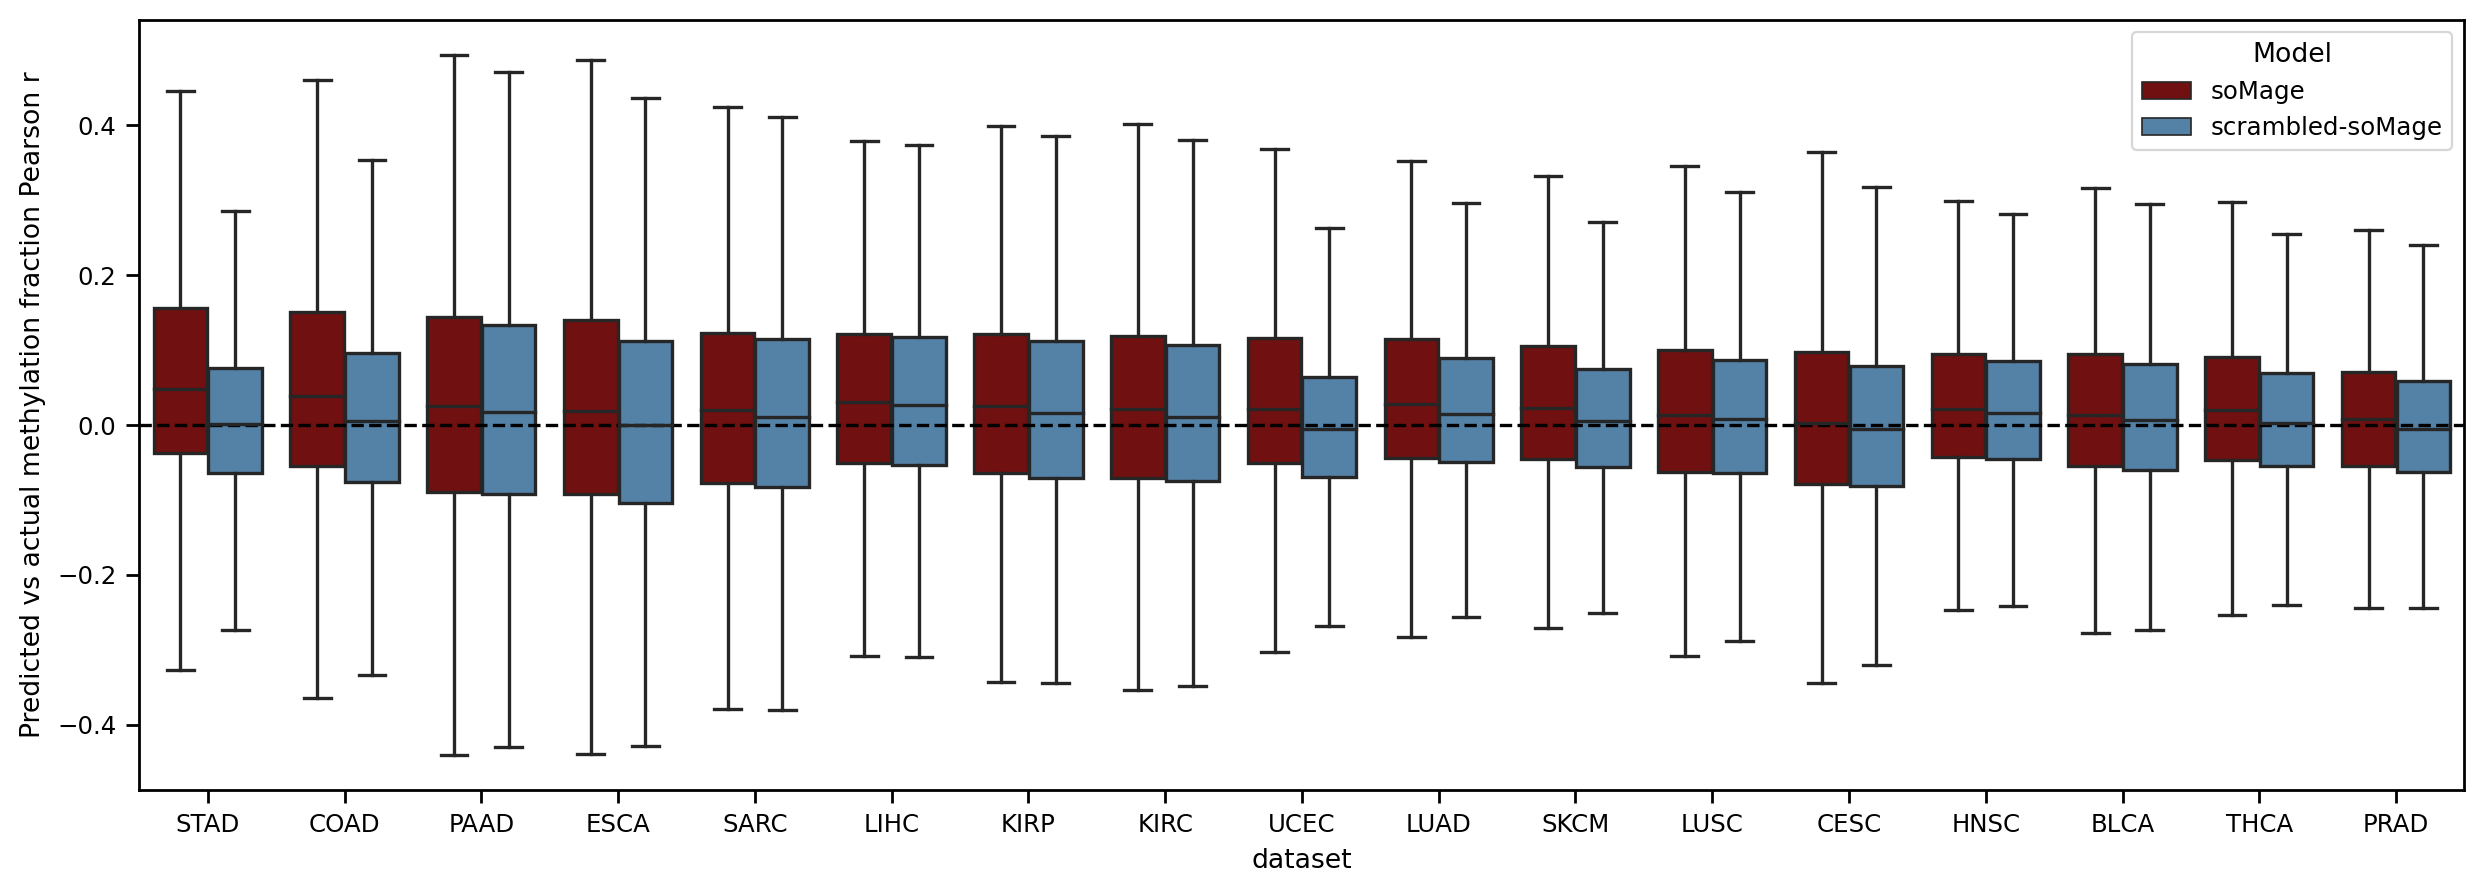

In [79]:
fig, axes = plt.subplots(figsize = (15,5))
sns.set_context('paper')
order = all_perf_by_dset_df.query("Model == 'soMage'").groupby('dataset')['AvP_methyl_pearson'].quantile(.75).sort_values(ascending = False).index
sns.boxplot(
    data=all_perf_by_dset_df,  y = 'AvP_methyl_pearson', x = 'dataset', hue = 'Model',
    ax = axes, showfliers=False, order = order,
    palette = ['maroon', 'steelblue'],
    hue_order=['soMage', 'scrambled-soMage']
    )
# plot y = 0 line
axes.axhline(y=0, color='black', linestyle='--')
plt.ylabel('Predicted vs actual methylation fraction Pearson r')
#plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/methyl_pred_perf_boxplots_4folds.svg', dpi=300, format = 'svg')

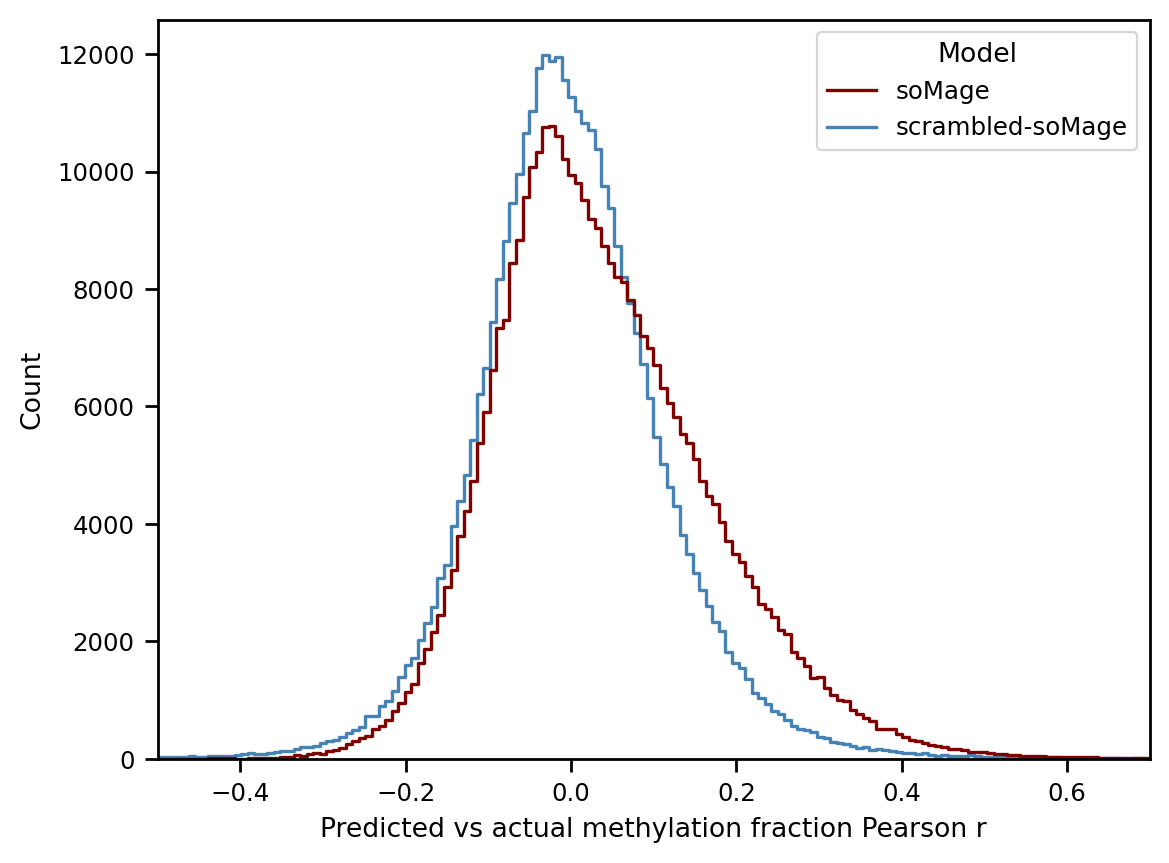

In [87]:
# testing set
sns.set_context('paper')
sns.histplot(
    data = all_perf_by_dset_df.query("dataset == 'UCEC'"),
    x = 'AvP_methyl_pearson', hue = 'Model',
    fill=False, common_norm=False, element="step",
    palette=['maroon', 'steelblue'], bins = 250,
    )
plt.xlabel('Predicted vs actual methylation fraction Pearson r')
plt.xlim(-0.5, .7)
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5C_methyl_pred_perf_UCEC.svg', dpi=300, format = 'svg')


(0.0, 12000.0)

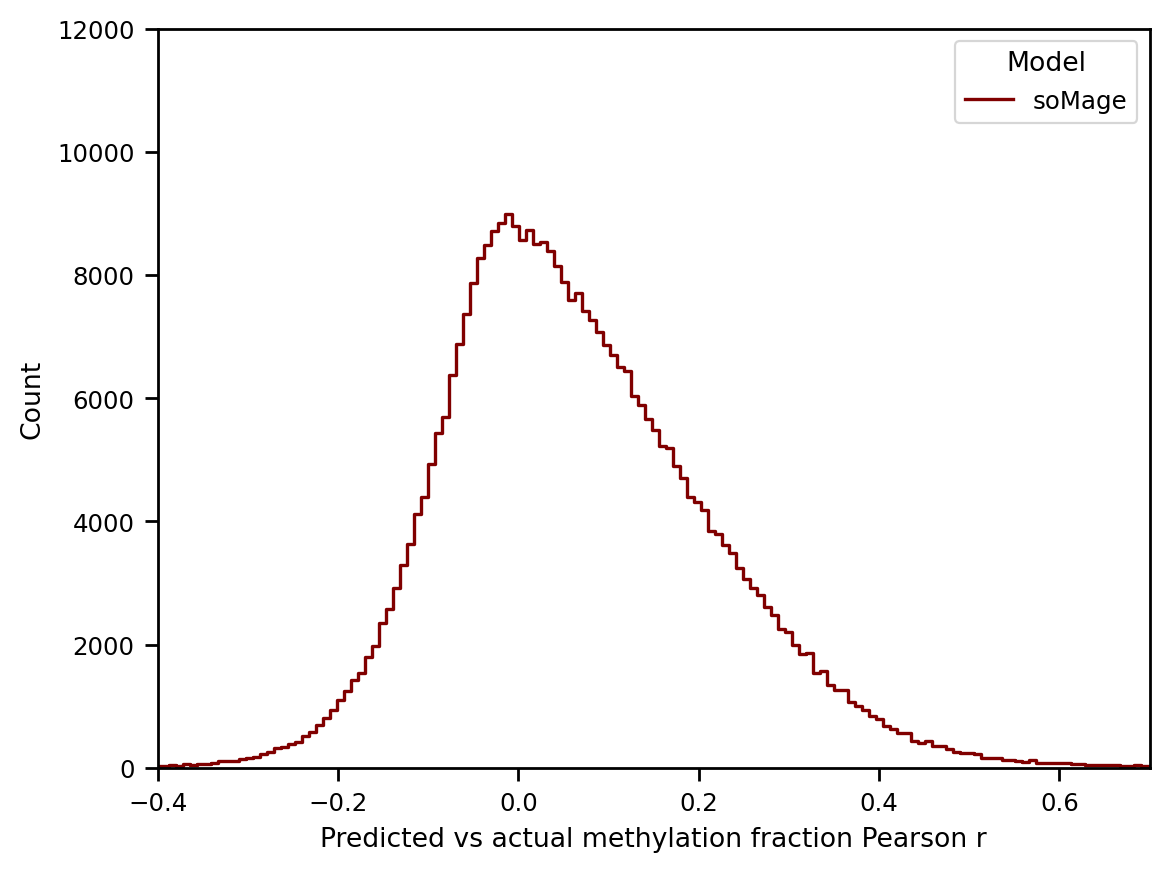

In [94]:
# testing set
sns.set_context('paper')

sns.histplot(
    data = all_perf_by_dset_df.query("dataset == 'STAD' and Model == 'soMage'"),
    x = 'AvP_methyl_pearson', hue = 'Model',
    fill=False, common_norm=False, element="step",
    palette=['maroon'], bins = 250,
    )
plt.xlabel('Predicted vs actual methylation fraction Pearson r')
plt.xlim(-0.4, .7)
plt.ylim(0, 12000)

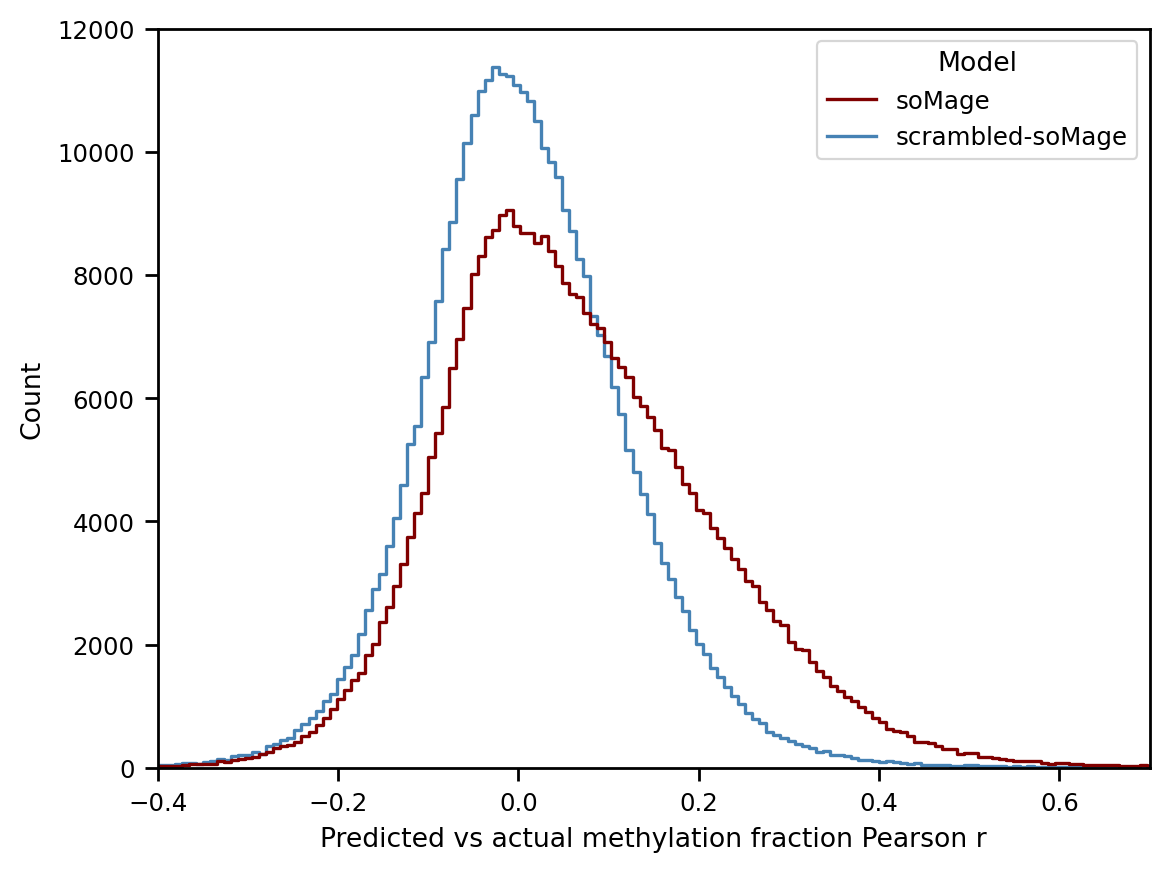

In [95]:
# testing set
sns.set_context('paper')
sns.histplot(
    data = all_perf_by_dset_df.query("dataset == 'STAD'"),
    x = 'AvP_methyl_pearson', hue = 'Model',
    fill=False, common_norm=False, element="step",
    palette=['maroon', 'steelblue'], bins = 250,
    )
plt.xlabel('Predicted vs actual methylation fraction Pearson r')
plt.xlim(-0.4, .7)
plt.ylim(0, 12000)
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5C_methyl_pred_perf_STAD.svg', dpi=300, format = 'svg')


#### 5B

In [20]:
somage_tcga.performance_by_dataset_df.query("dataset == 'UCEC' and cpg == 'cg09581049'")

,cpg,AvP_methyl_pearson,AvP_methyl_spearman,AvP_methyl_mi,AvP_methyl_mae,Pmethyl_v_Age_pearson_abs,Pmethyl_v_Age_spearman_abs,Pmethyl_v_Age_mi,train_AvP_methyl_pearson,train_AvP_methyl_spearman,train_AvP_methyl_mi,train_Pmethyl_v_Age_spearman_abs,train_Pmethyl_v_Age_mi,train_Amethyl_v_Age_pearson_abs,train_Amethyl_v_Age_spearman_abs,train_Amethyl_v_Age_mi,dataset
561977,cg09581049,0.597503,0.579472,0.047662,0.116198,0.276215,0.283935,0.233289,0.699911,0.695792,0.119982,0.214128,0.102465,0.237564,0.228274,0.109262,UCEC


In [ ]:
# cpg = 'cg02391549', dataset = 'SKCM',
# cpg = 'cg09581049', dataset = 'UCEC'
dfs = []
for cv_num in [0,1,2,3]:
    for_box_df = somage_tcga_dict[cv_num].plot_real_vs_predicted_methylation(
        cpg = 'cg09581049', dataset = 'UCEC', sample_set='test'
        )
    dfs.append(for_box_df)
    
all_box_df = pd.concat(dfs).reset_index(drop=True)

In [186]:
all_box_df.corr()

The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.


,Predicted,Actual
Predicted,1.000000,0.645222
Actual,0.645222,1.000000


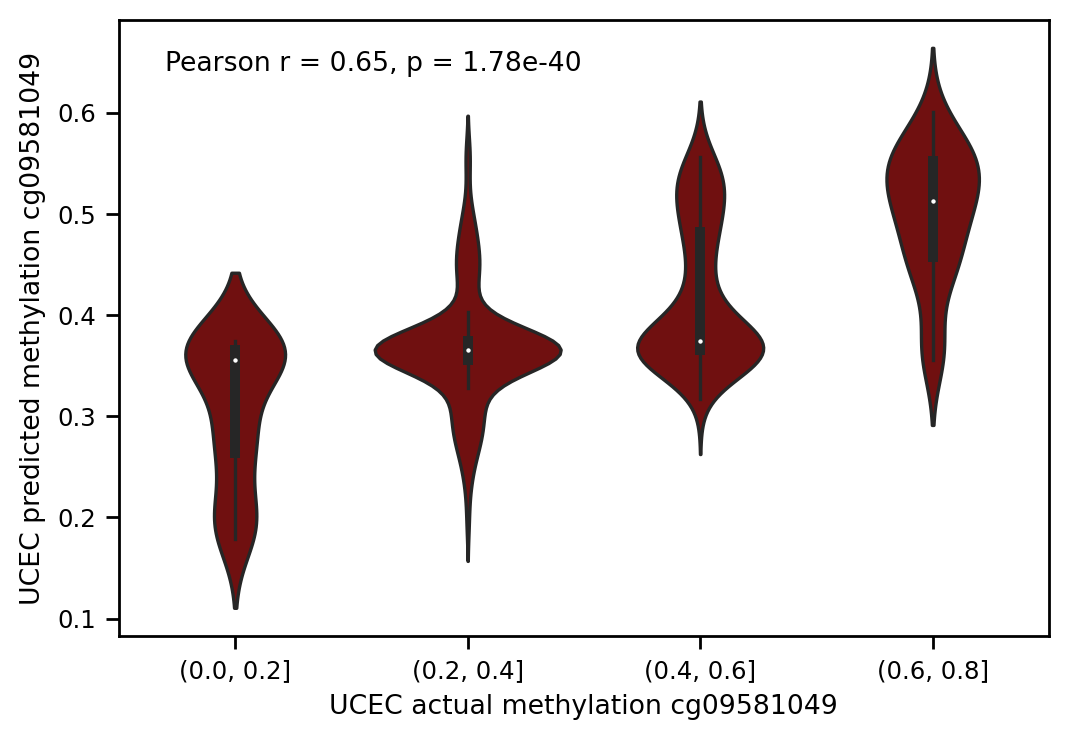

In [189]:
fig, axes = plt.subplots(figsize=(6, 4), dpi = 100)
sns.set_context('paper')
sns.violinplot(
            x='actual_bin', y='Predicted', data=all_box_df, ax=axes,
            palette=['maroon'], alpha = .5
        )
axes.set_ylabel(f"UCEC predicted methylation {'cg09581049'}")
axes.set_xlabel(f"UCEC actual methylation {'cg09581049'}")
# add pearson r to plot
r, p = pearsonr(all_box_df['Actual'], all_box_df['Predicted'])
axes.text(
    x = 0.05, y = 0.95, s = f"Pearson r = {r:.2f}, p = {p:.2e}", 
    horizontalalignment='left', verticalalignment='top', transform=axes.transAxes
)
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5B_methyl_pred_example_combined_folds.svg', dpi=300, format = 'svg')

#### 5E: performance barplots

In [72]:
"""best_clock_results = {}
for cv_num in [0,1,2,3]:
    best_clock_results[cv_num] = somage_tcga_dict[cv_num].scan_for_best_clock(
        datasets = somage_tcga_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics =['train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],#, 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
        number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
        training_methylation_types = ['pred', 'actual'],
        train_sets = ['train'],
        model_types = ['xgboost'], # 'elasticnet', 
        train_tissues = ['self']
        )
# write to pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/trained_clocks/4_folds_best_clocks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(best_clock_results, f)"""
# read from pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/trained_clocks/4_folds_best_clocks.pkl"
with open(fn, 'rb') as f:
    best_clock_results = pickle.load(f)
    
# combine best_clock_results dict into df
best_clock_results_list = []
for cv_num in [0,1,2,3]:
    best_clock_results[cv_num]['cv_num'] =  cv_num
    best_clock_results_list.append(best_clock_results[cv_num])
best_clock_results_df = pd.concat(best_clock_results_list).reset_index(drop=True)

In [73]:
"""scramble_best_clock_results = {}
for cv_num in [0,1,2,3]:
    scramble_best_clock_results[cv_num] = scrambled_somage_tcga_dict[cv_num].scan_for_best_clock(
        datasets = scrambled_somage_tcga_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics =['train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],#, 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
        number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
        training_methylation_types = ['pred', 'actual'],
        train_sets = ['train'],
        model_types = ['xgboost'], # 'elasticnet', 
        train_tissues = ['self']
        )
    
# write to pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/trained_clocks/scramble_4_folds_best_clocks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(scramble_best_clock_results, f)"""
# read from pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_tcga_somage_output/trained_clocks/scramble_4_folds_best_clocks.pkl"
with open(fn, 'rb') as f:
    scramble_best_clock_results = pickle.load(f)
    
# combine best_clock_results dict into df
scramble_best_clock_results_list = []
for cv_num in [0,1,2,3]:
    scramble_best_clock_results[cv_num]['cv_num'] =  cv_num
    scramble_best_clock_results_list.append(scramble_best_clock_results[cv_num])
scramble_best_clock_results_df = pd.concat(scramble_best_clock_results_list).reset_index(drop=True)

In [78]:
# read in actual clock results
# read in all sample model and make predictions
clock_dir = "/cellar/users/zkoch/methylation_and_mutation/data/final_tcga_data/actual_methyl_epi_clocks"
real_methyl_models = {}
performances = []
dsets = best_clock_results_df['dataset'].unique().tolist()
# read from pickle
for cv_num in [0,1,2,3,4]:
    with open(os.path.join(clock_dir, f'epiClock_TCGA_cv{cv_num}_all_actualMethyl_enet.pkl'), 'rb') as f:
        all_sample_model = pickle.load(f)
    real_methyl_models[cv_num] = all_sample_model
    for dataset in dsets:
        # get this cv_num test samples
        test_samples = mut_feat_tcga_dict[cv_num].test_samples
        # and intersect with this datasets samples
        test_samples = list(
            set(test_samples).intersection(
                set(all_methyl_age_df_t.query("dataset == @dataset").index.tolist())
            ))
        # make prediction
        predicted_ages = all_sample_model.predict(all_methyl_age_df_t.loc[test_samples].iloc[:, 3:])
        actual_ages = all_methyl_age_df_t.loc[test_samples, 'age_at_index'].values
        pearson = pearsonr(predicted_ages, actual_ages)[0]
        spearman = spearmanr(predicted_ages, actual_ages)[0]
        performances.append({
            'dataset': dataset,
            'cv_num': cv_num,
            'pearson': pearson,
            'spearman': spearman,
            'Model': 'Actual methylation',
            'y_pred': predicted_ages,
            'y_test': actual_ages
            })
        
    print(f"Done with cv_num {cv_num}", flush = True)
        
actual_performance_df = pd.DataFrame(performances)

Done with cv_num 0
Done with cv_num 1
Done with cv_num 2
Done with cv_num 3
Done with cv_num 4



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(-0.2, 0.9)

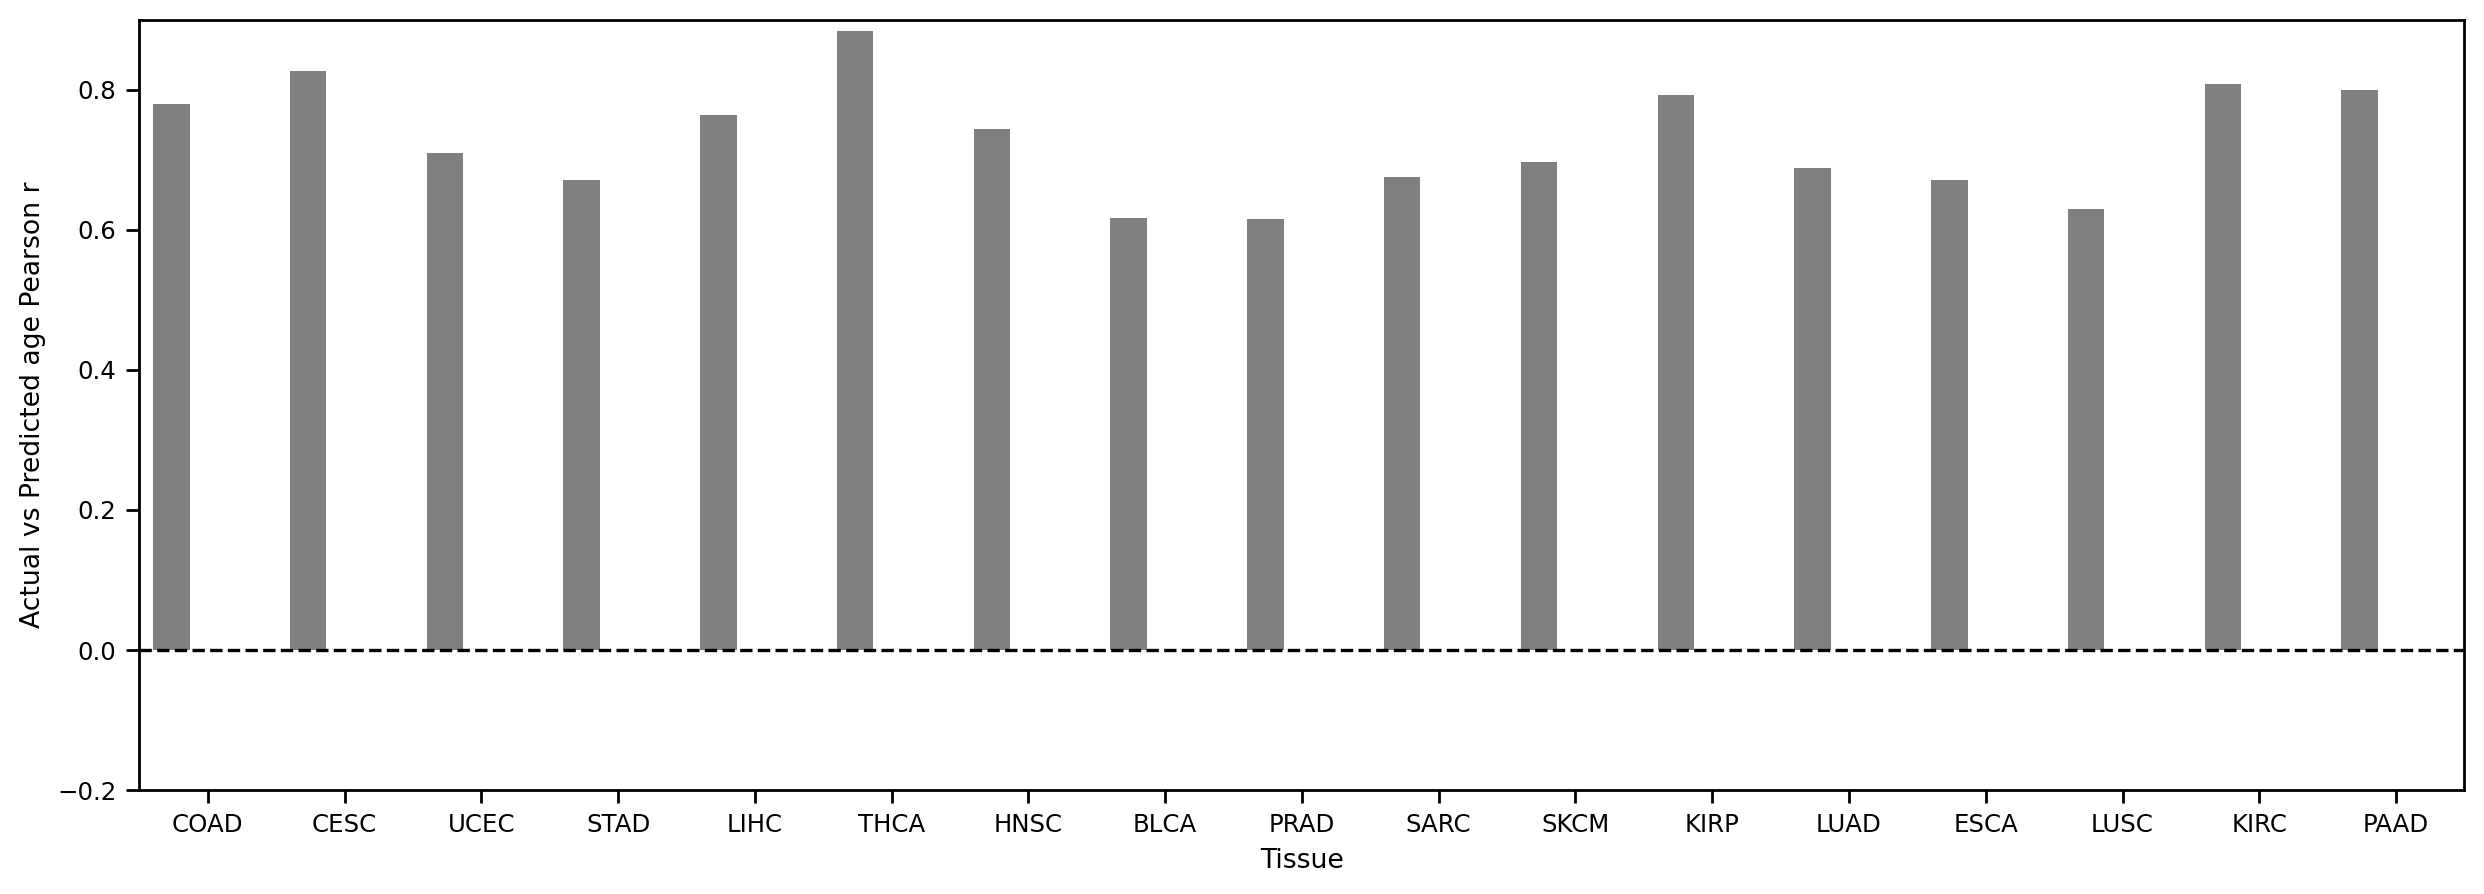

In [79]:
fig, axes = plt.subplots(figsize = (15,5), dpi = 100)
sns.set_context('paper')
# get mean value of pearson for each dataset 
filtered_df = best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
scramble_filtered_df = scramble_best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
# combine 
filtered_df['Model'] = 'soMage'
scramble_filtered_df['Model'] = 'scrambled-soMage'
combined_df = pd.concat(
    [filtered_df, scramble_filtered_df, actual_performance_df]
    ).reset_index(drop=True)
order = filtered_df.groupby('dataset')['pearson'].mean().sort_values(ascending=False).index

sns.barplot(
    data=combined_df,  y = 'pearson', x = 'dataset', hue = 'Model',
    ax = axes, errorbar = None, capsize=.15, linewidth=1,
    errcolor="black", errwidth=1.5, 
    order  = order,
    palette = ['grey', 'white', 'white'], #edgecolor = 'black',
    hue_order=[ 'Actual methylation', 'soMage', 'scrambled-soMage'],
    )
plt.ylabel('Actual vs Predicted age Pearson r')
plt.xlabel('Tissue')
# no legend
axes.get_legend().remove()
# plot y = 0 line
axes.axhline(y=0, color='black', linestyle='--')
plt.ylim(-0.2, 0.9)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


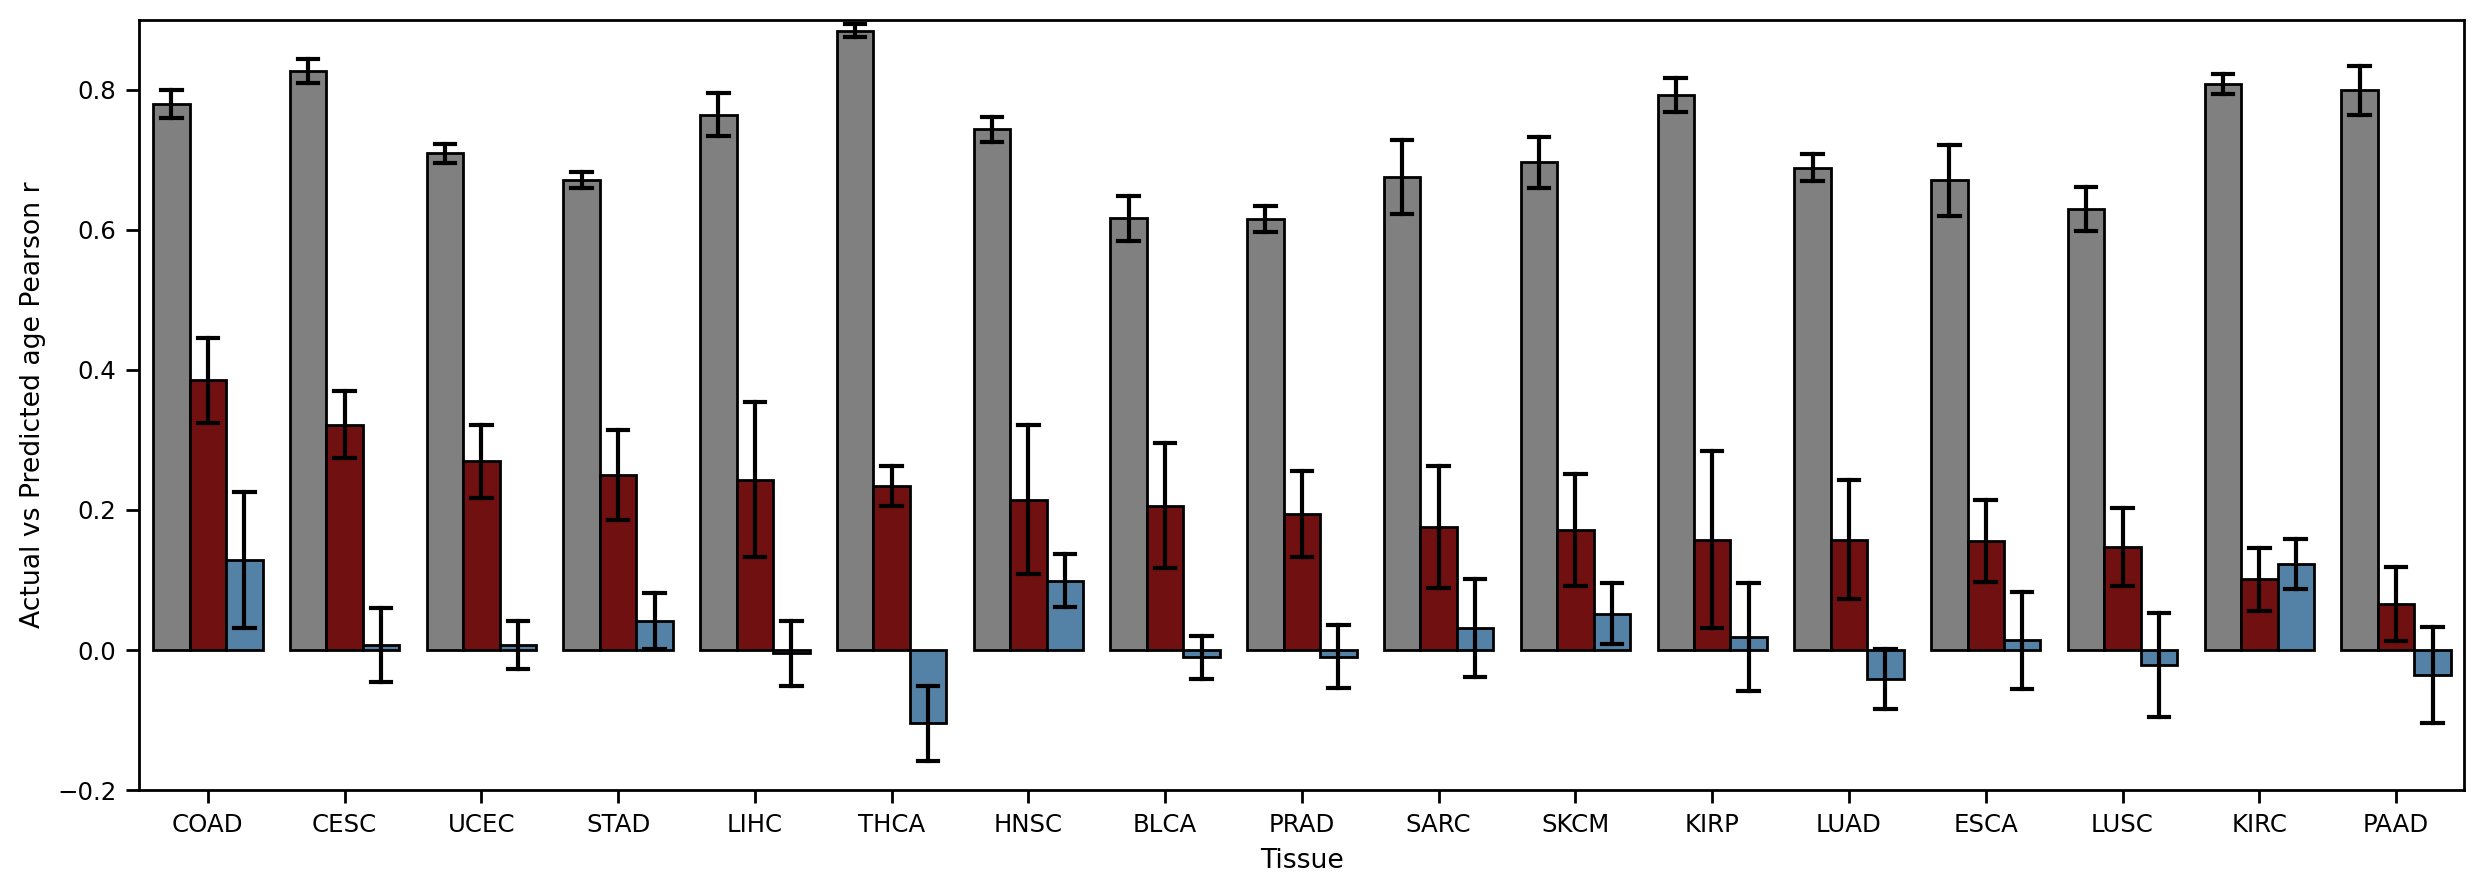

In [94]:
fig, axes = plt.subplots(figsize = (15,5), dpi = 100)
sns.set_context('paper')
# get mean value of pearson for each dataset 
filtered_df = best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
scramble_filtered_df = scramble_best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
# combine 
filtered_df['Model'] = 'soMage'
scramble_filtered_df['Model'] = 'scrambled-soMage'
combined_df = pd.concat(
    [filtered_df, scramble_filtered_df, actual_performance_df]
    ).reset_index(drop=True)
order = filtered_df.groupby('dataset')['pearson'].mean().sort_values(ascending=False).index

sns.barplot(
    data=combined_df,  y = 'pearson', x = 'dataset', hue = 'Model',
    ax = axes, errorbar = 'se', capsize=.15, linewidth=1,
    errcolor="black", errwidth=1.5, order  = order,
    palette = ['grey', 'maroon', 'steelblue'], edgecolor = 'black',
    hue_order=[ 'Actual methylation', 'soMage', 'scrambled-soMage']
    )
plt.ylabel('Actual vs Predicted age Pearson r')
plt.xlabel('Tissue')
# do not show legend
axes.get_legend().remove()
plt.ylim(-0.2, 0.9)
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5E_clock_performance_barplots.svg', dpi=300, format = 'svg')


#sns.stripplot(data=filtered_df,  y = 'pearson', x = 'dataset', ax = axes, order = order, color = 'black', alpha = 0.5)

# angle the x labels
#_=plt.xticks(rotation=45, ha='right')

#### 5A: feature matrix and methylation bar

In [9]:
example_cpg = 'cg09581049'

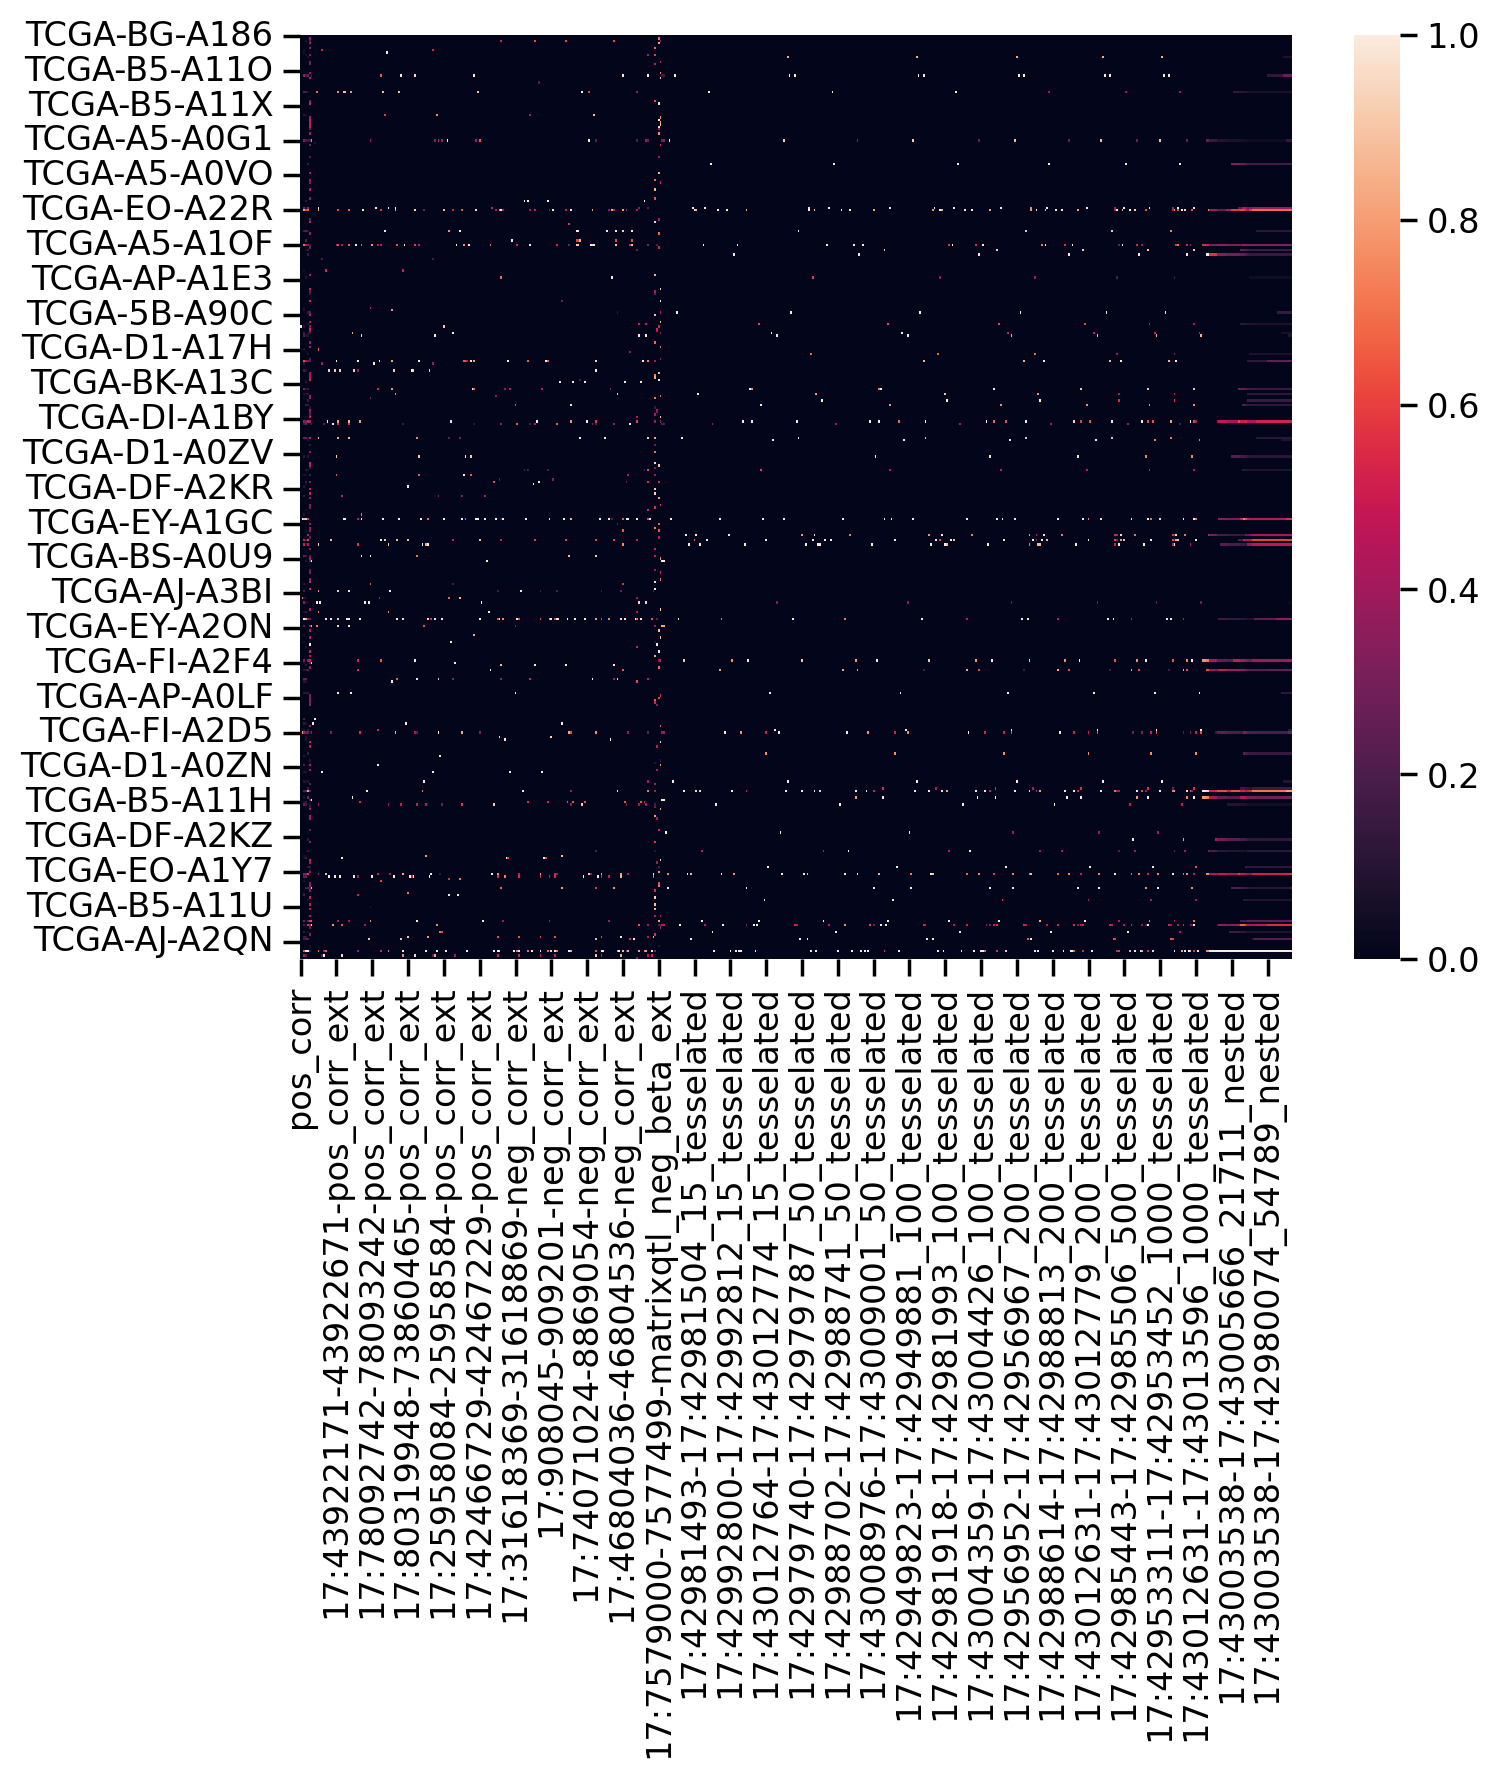

In [10]:
feat_mat = somage_tcga.plot_feature_matrix_heatmap(cpg =example_cpg, dataset = "UCEC", only_agg_feats = True)

In [32]:
feat_mat.to_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/example_feat_mat_UCEC_cg09581049.parquet')

In [5]:
feat_mat = pd.read_parquet('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/example_feat_mat_UCEC_cg09581049.parquet')

<Axes: >

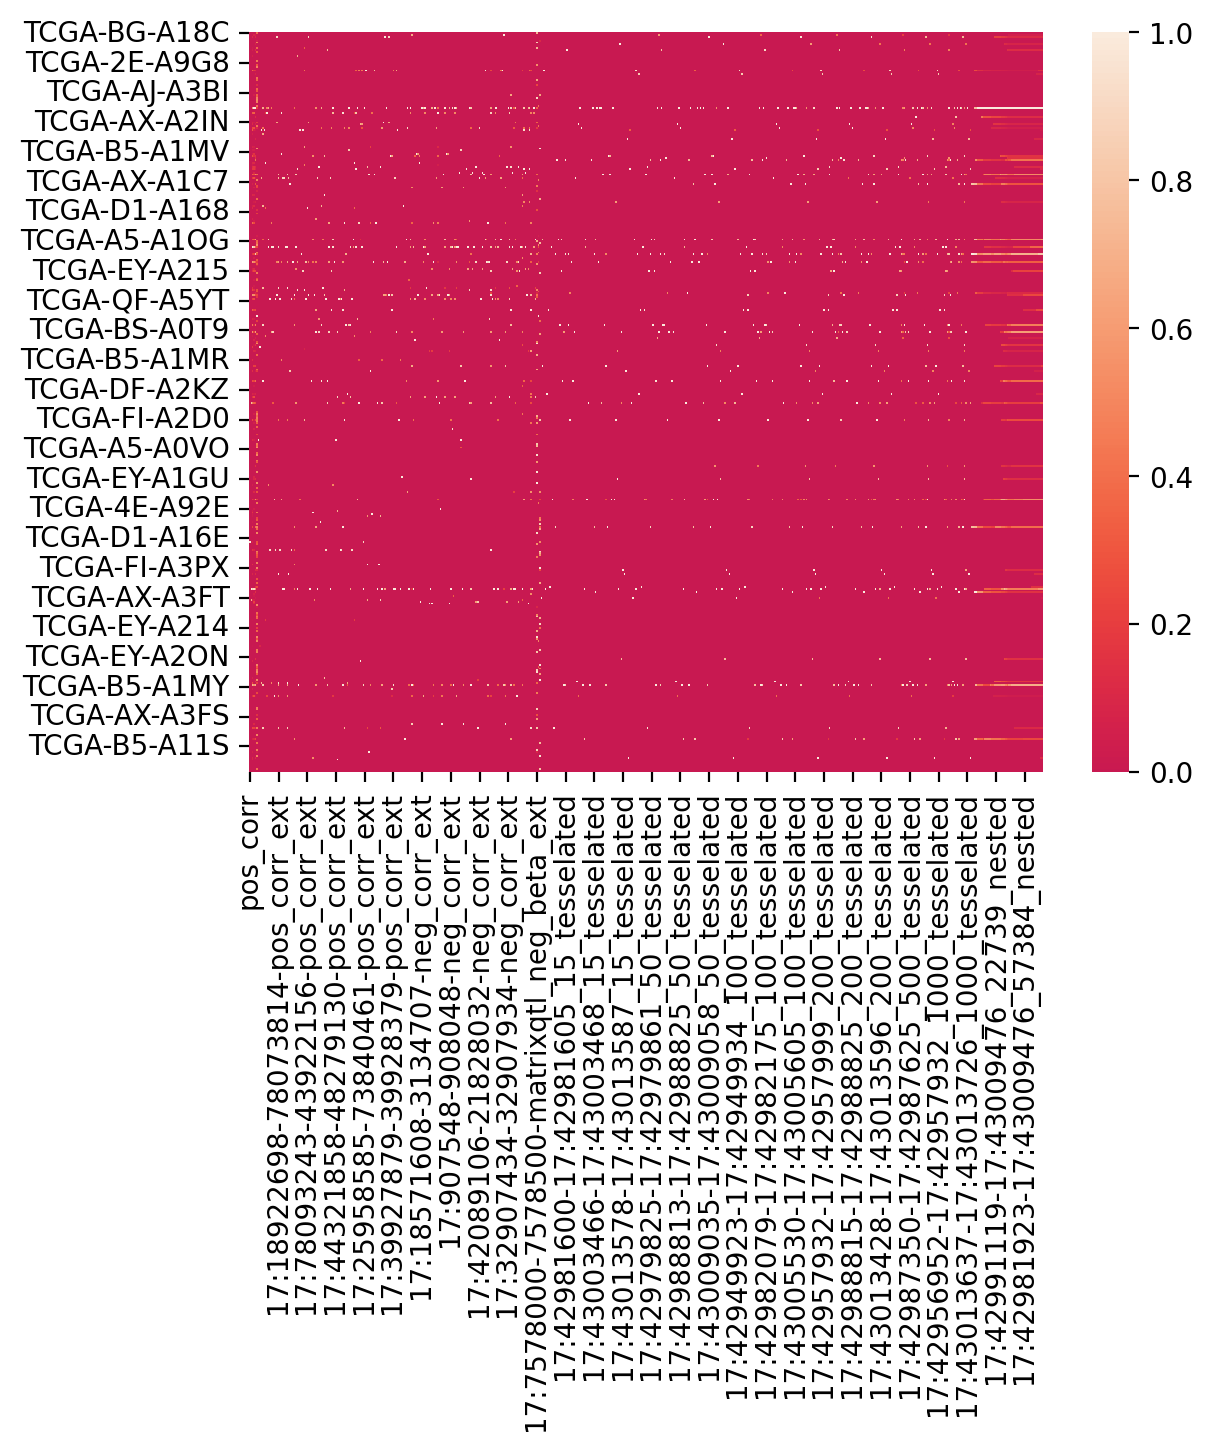

In [19]:
sns.heatmap(feat_mat, cmap = 'rocket', vmin = 0, vmax = 1, center = .01)

In [11]:
# also plot example methylation
tp_cpg = all_methyl_age_df_t.query("dataset == 'UCEC'")[example_cpg].values

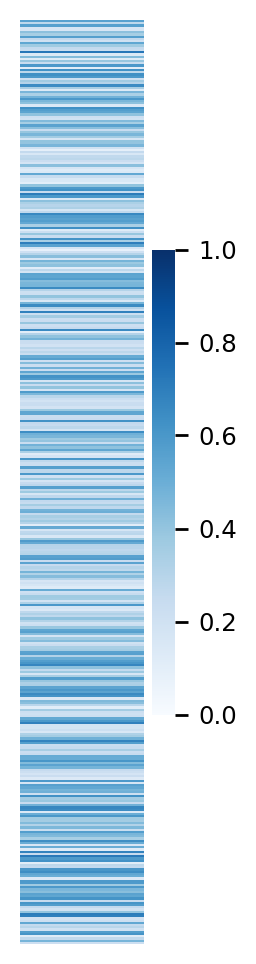

In [19]:
fig, axes = plt.subplots(figsize = (1,6), dpi = 100)
sns.set_context('paper')
sns.heatmap(
    #all_methyl_age_df_t.loc[dataset_train_samples + dataset_test_samples, best_pred_cpgs[9] ].values.reshape(-1,1),
    tp_cpg.reshape(-1,1),
    cmap = 'Blues', ax = axes, vmin=0, vmax=1, cbar=True
    )
plt.xticks([])
plt.yticks([])
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5A_methyl_values.svg', dpi=300, format = 'svg')

#### 5D: example scatterplot

,dataset,cv_num,pearson,spearman,Model,y_pred,y_test
1,UCEC,0,0.672997,0.631140,Actual methylation,"[61.382120408286, 60.075790961747416, 64.55874...","[62, 66, 67, 45, 76, 55, 74, 72, 56, 60, 73, 6..."
18,UCEC,1,0.679395,0.657928,Actual methylation,"[57.706706096860934, 78.94158127468326, 63.048...","[60, 55, 71, 61, 51, 35, 77, 65, 78, 76, 87, 6..."
35,UCEC,2,0.724683,0.693642,Actual methylation,"[71.59978747324509, 75.89137991959598, 60.8959...","[60, 80, 71, 63, 77, 65, 58, 60, 77, 72, 79, 6..."
52,UCEC,3,0.746963,0.711911,Actual methylation,"[67.80628148191516, 69.57750990054939, 52.5170...","[65, 86, 56, 65, 53, 61, 31, 65, 78, 58, 60, 7..."
69,UCEC,4,0.721631,0.716177,Actual methylation,"[56.162755626411375, 64.51316449211328, 42.482...","[58, 64, 37, 74, 63, 64, 73, 70, 56, 51, 80, 7..."


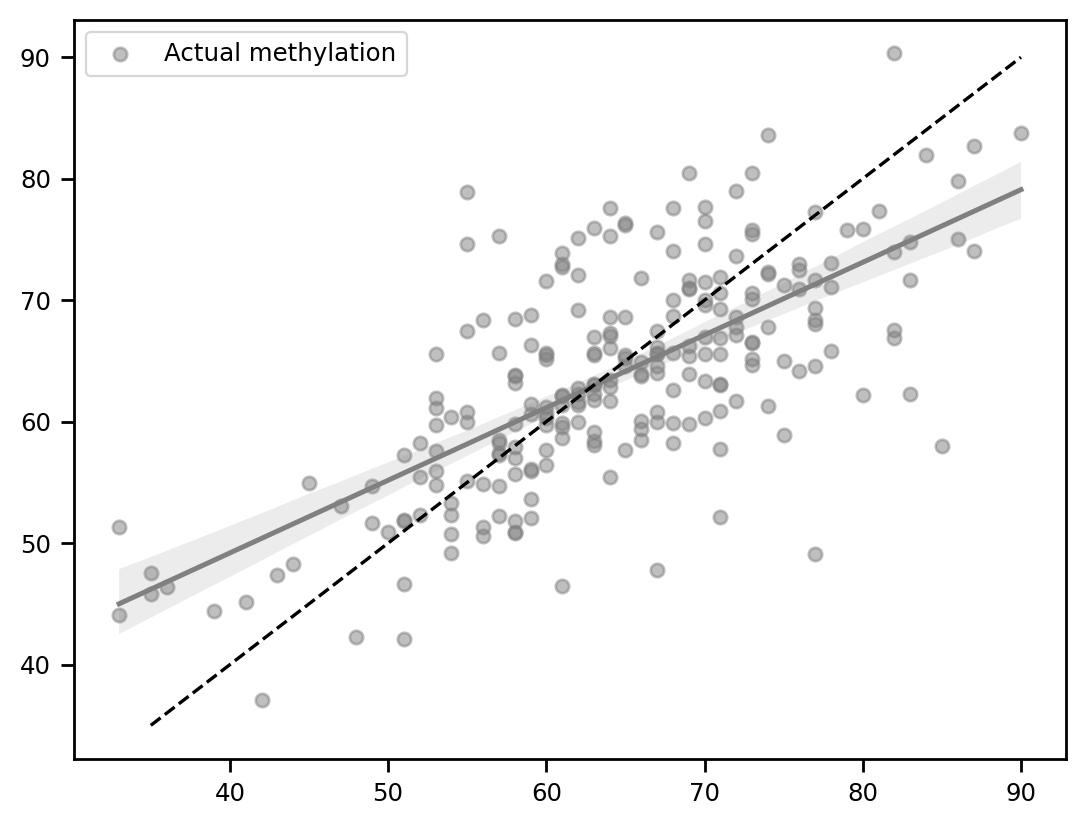

In [65]:
#ucec_predictions = filtered_df.query("dataset == 'UCEC' and cv_num < 2")
#sns.regplot(x = np.concatenate(ucec_predictions['y_test'].values), y =  np.concatenate(ucec_predictions['y_pred'].values), color = 'Maroon', scatter_kws={'alpha':0.5}, label = 'soMage')
epi_ucec_pred = actual_performance_df.query("dataset == 'UCEC' and cv_num < 3")
sns.regplot(x = np.concatenate(epi_ucec_pred['y_test'].values), y =  np.concatenate(epi_ucec_pred['y_pred'].values), color = 'Grey', scatter_kws={'alpha':0.5}, label = 'Actual methylation')
# show legend
plt.legend()
#  plot y = x
plt.plot(np.linspace(35, 90), np.linspace(35, 90), color = 'black', linestyle = '--')

87

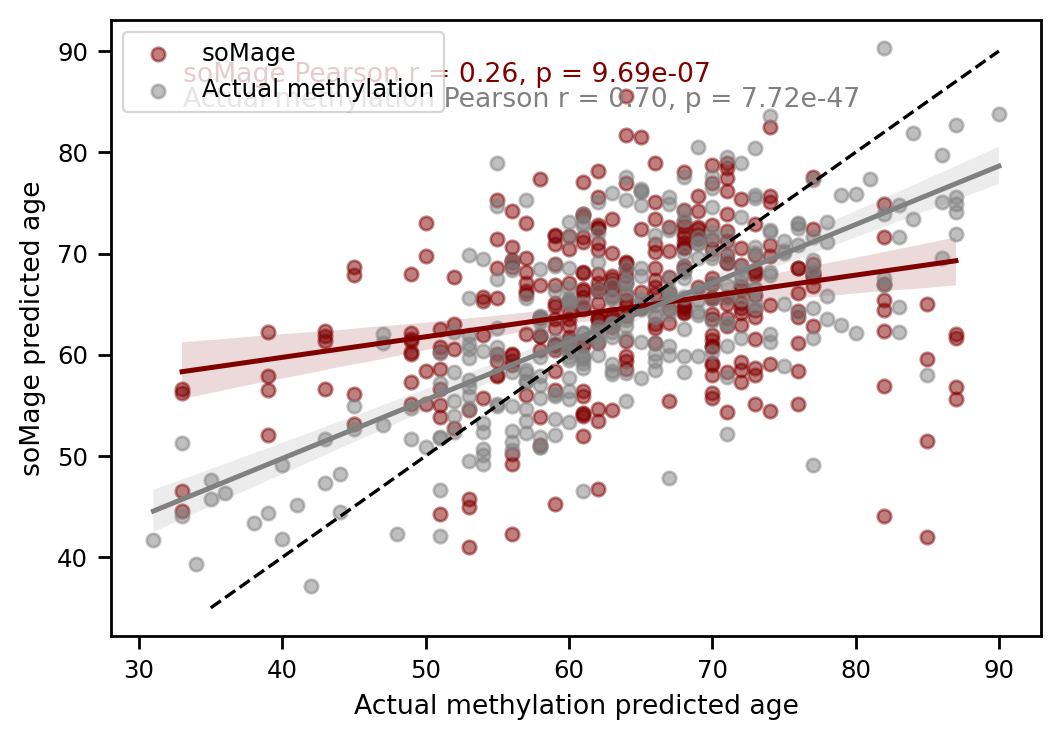

In [108]:
sns.set_context('paper')
fig, axes = plt.subplots(figsize = (6, 4), dpi = 100)

ucec_predictions = filtered_df.query("dataset == 'UCEC' and cv_num < 4")
sns.regplot(x = np.concatenate(ucec_predictions['y_test'].values), y =  np.concatenate(ucec_predictions['y_pred'].values), color = 'Maroon', scatter_kws={'alpha':0.5}, label = 'soMage', ax = axes)
epi_ucec_pred = actual_performance_df.query("dataset == 'UCEC' and cv_num < 4")
sns.regplot(x = np.concatenate(epi_ucec_pred['y_test'].values), y =  np.concatenate(epi_ucec_pred['y_pred'].values), color = 'Grey', scatter_kws={'alpha':0.5}, label = 'Actual methylation', ax = axes)
# show legend
plt.legend()
#  plot y = x
plt.plot(np.linspace(35, 90), np.linspace(35, 90), color = 'black', linestyle = '--')
plt.ylabel('soMage predicted age')
plt.xlabel('Actual methylation predicted age')

somage_pearson_r = pearsonr(np.concatenate(ucec_predictions['y_test'].values), np.concatenate(ucec_predictions['y_pred'].values))

actual_methyl_pearson_r = pearsonr(np.concatenate(epi_ucec_pred['y_test'].values), np.concatenate(epi_ucec_pred['y_pred'].values))
# add pearson r to plot
plt.text(
    x = np.concatenate(ucec_predictions['y_test'].values).min() + 0.05,
    y = np.concatenate(ucec_predictions['y_test'].values).max() - 0.05,
    s = f"soMage Pearson r = {somage_pearson_r[0]:.2f}, p = {somage_pearson_r[1]:.2e}",
    color = 'maroon'
)
plt.text(
    x = np.concatenate(ucec_predictions['y_test'].values).min() + 0.05,
    y = np.concatenate(ucec_predictions['y_test'].values).max() - 2.5,
    s = f"Actual methylation Pearson r = {actual_methyl_pearson_r[0]:.2f}, p = {actual_methyl_pearson_r[1]:.2e}",
    color = 'grey'
)
    

plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5D_soMage_vs_actual_methylation_scatter_UCEC.svg', dpi=300, format = 'svg')

In [89]:
# apply to testing samples from CV 0
test_samples_ucec = set(mut_feat_tcga.test_samples).intersection(set(all_methyl_age_df_t.query("dataset == 'UCEC'").index))

In [93]:
test_methyl_df = all_methyl_age_df_t.loc[test_samples_ucec, :].iloc[:,3:]
# apply clock
pred_ages = best_UCEC_clock.predict(test_methyl_df)

Passing a set as an indexer is deprecated and will raise in a future version. Use a list instead.


In [97]:
pearsonr(pred_ages, best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values)


PearsonRResult(statistic=0.6044240432174166, pvalue=1.444056052545577e-09)

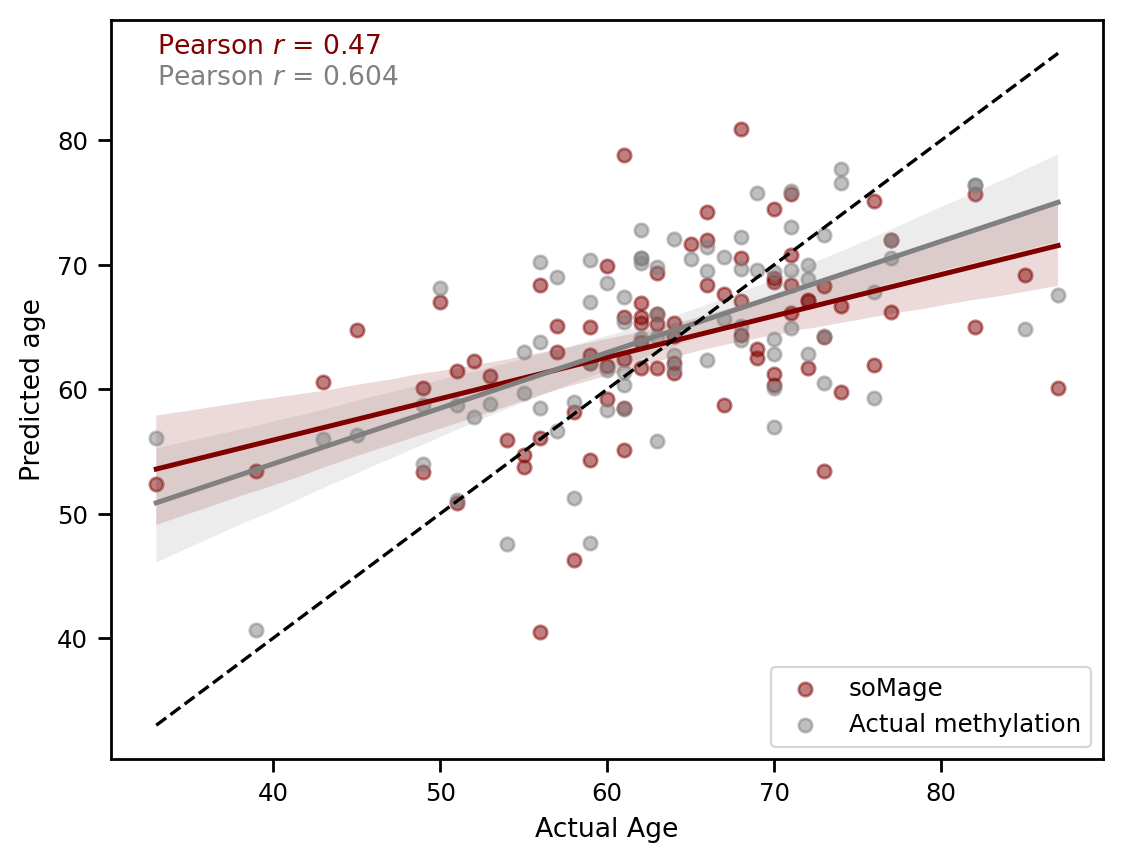

In [172]:
row_num = 278
sns.set_context('paper')
sns.regplot(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values, 
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_pred'], 
    color = 'maroon', scatter_kws={'alpha':0.5}, label = 'soMage'
    )
somage_pearson_r = round(pearsonr(best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_pred'], best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values).statistic, 2)

sns.regplot(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values,
    y = pred_ages, 
    color = 'grey', scatter_kws={'alpha':0.5}, label = 'Actual methylation'
    )
actual_methyl_pearson_r = round(pearsonr(pred_ages, best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values).statistic, 3)
# add soMage pearson r to plot, colored maroon
plt.text(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min() + 0.05,
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max() - 0.05,
    s = r"Pearson $r$ = {}".format(somage_pearson_r),
    color = 'maroon'
    )
plt.text(
    x = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min() + 0.05,
    y = best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max() - 2.5,
    s = r"Pearson $r$ = {}".format(actual_methyl_pearson_r),
    color = 'grey'
    )
# show legend 
plt.legend( loc='lower right')
#sns.regplot(x = best_clock_scan_results_df_scrambled.loc[15, 'y_test'].values, y = best_clock_scan_results_df_actual.loc[15, 'y_pred'], color = 'red', scatter_kws={'alpha':0.5})
# add y = x line based on min and max of y_test, using axh 
plt.plot(
    [best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max()],
    [best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.min(), best_clock_scan_results_df_tcga_agg_only.loc[row_num, 'y_test'].values.max()],
    color = 'black', linestyle = '--',
    )
plt.xlabel('Actual Age')
plt.ylabel('Predicted age')
plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5D_soMage_vs_actual_methylation_UCEC.svg', dpi = 300, format = 'svg')

#### Mutation burden predicting age 

In [19]:
mut_burden = all_mut_w_age_df['case_submitter_id'].value_counts()
ct_mut_burden = all_mut_w_age_df.loc[all_mut_w_age_df['mutation'] == 'C>T', 'case_submitter_id'].value_counts()
age = all_methyl_age_df_t['age_at_index']
dataset = all_methyl_age_df_t['dataset']
# merge these into a df
mut_burden_df = pd.DataFrame({
    'mut_burden': mut_burden,
    'ct_mut_burden': ct_mut_burden,
    'age': age,
    'dataset': dataset
    }).reset_index().rename(columns = {'index': 'case_submitter_id'})
# drop any row with a nan
mut_burden_df = mut_burden_df.dropna().reset_index(drop=True)
mut_burden_df['log_mut_burden'] = np.log(mut_burden_df['mut_burden'])


In [263]:
# build a linear regression model to predict age from mut burden with 5-fold cross validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
mut_count = 'mut_burden' # 'ct_mut_burden'
performances = []
for dataset in mut_burden_df['dataset'].unique():
    this_dataset_df = mut_burden_df.query("dataset == @dataset").reset_index(drop=True)
    # split into train and test sets and iterate
    cv = KFold(n_splits=5, shuffle=True, random_state=4)
    for train_index, test_index in cv.split(this_dataset_df):
        # train the model
        model.fit(this_dataset_df.loc[train_index, mut_count].values.reshape(-1, 1), this_dataset_df.loc[train_index, 'age'])
        # evaluate the model
        pred_ages = model.predict(this_dataset_df.loc[test_index, mut_count].values.reshape(-1, 1))
        # calculate r2
        r = pearsonr(this_dataset_df.loc[test_index, 'age'], pred_ages).statistic
        # calculate mae
        mae = mean_absolute_error(this_dataset_df.loc[test_index, 'age'], pred_ages)
        performances.append({'dataset': dataset, 'pearson': r, 'mae': mae, 'y_pred': pred_ages.tolist(), 'y_test': this_dataset_df.loc[test_index, 'age'].values.tolist()})
mut_burden_perf_df = pd.DataFrame(performances)

# keep only top 20 datasets
top_20_dsets = all_methyl_age_df_t['dataset'].value_counts().index[:20].to_list()
for dset in top_20_dsets:
    if dset == 'BRCA' or dset == 'LGG'  or dset == 'OV' or dset == 'LAML':
        top_20_dsets.remove(dset)
mut_burden_perf_df = mut_burden_perf_df.query("dataset in @top_20_dsets").reset_index(drop=True)

An input array is constant; the correlation coefficient is not defined.


Text(0.5, 1.0, 'Predicting age from mutation burden')

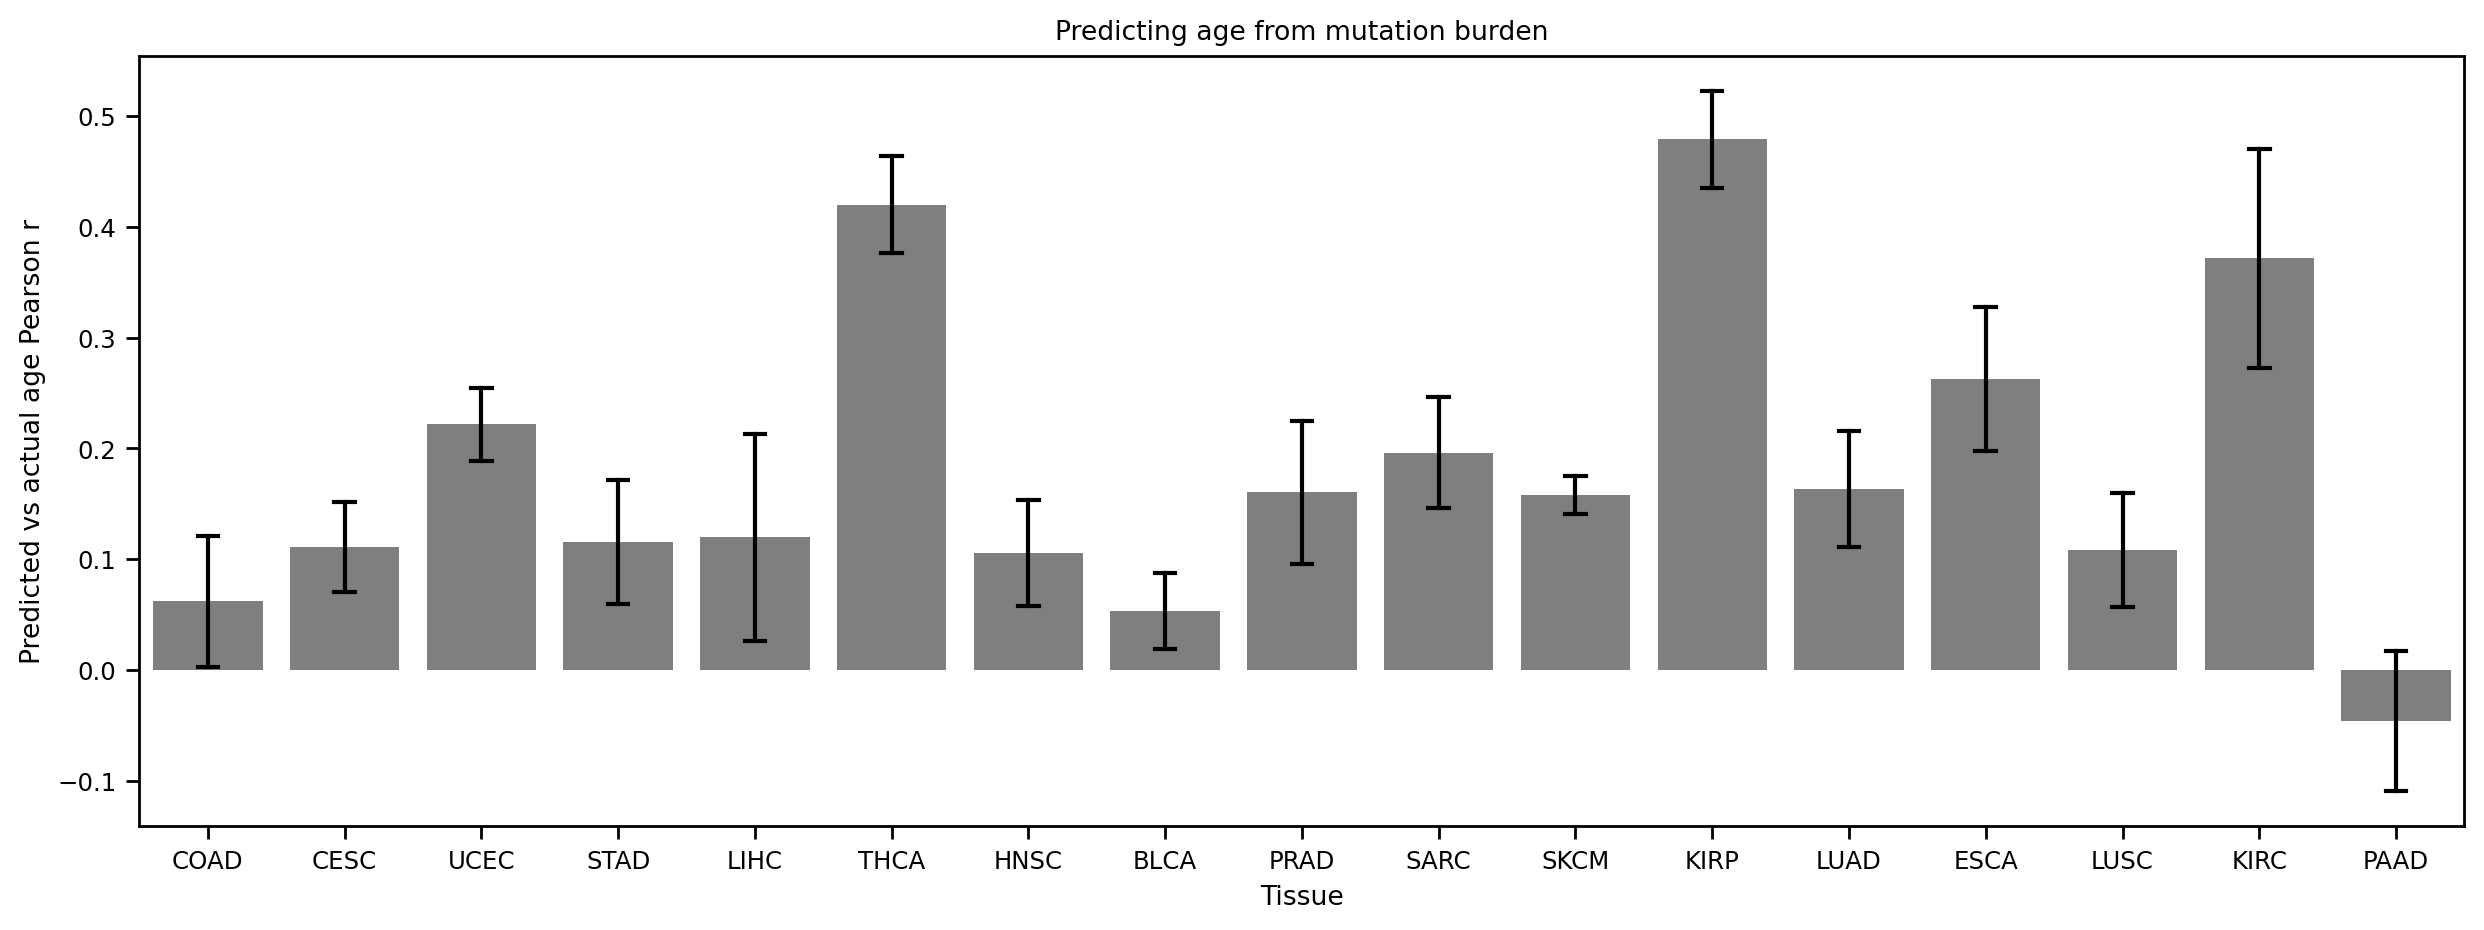

In [158]:
fig, axes = plt.subplots(figsize = (15,5), dpi = 100)
sns.barplot(data=mut_burden_perf_df,  y = 'pearson', x = 'dataset',  color = 'black', alpha = 0.5, ax = axes, errorbar = 'se', capsize=.15, linewidth=1,
    errcolor="black", errwidth=1.5, order = order)
plt.xlabel('Tissue')
plt.ylabel('Predicted vs actual age Pearson r')
plt.title('Predicting age from mutation burden')


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(-0.2, 0.9)

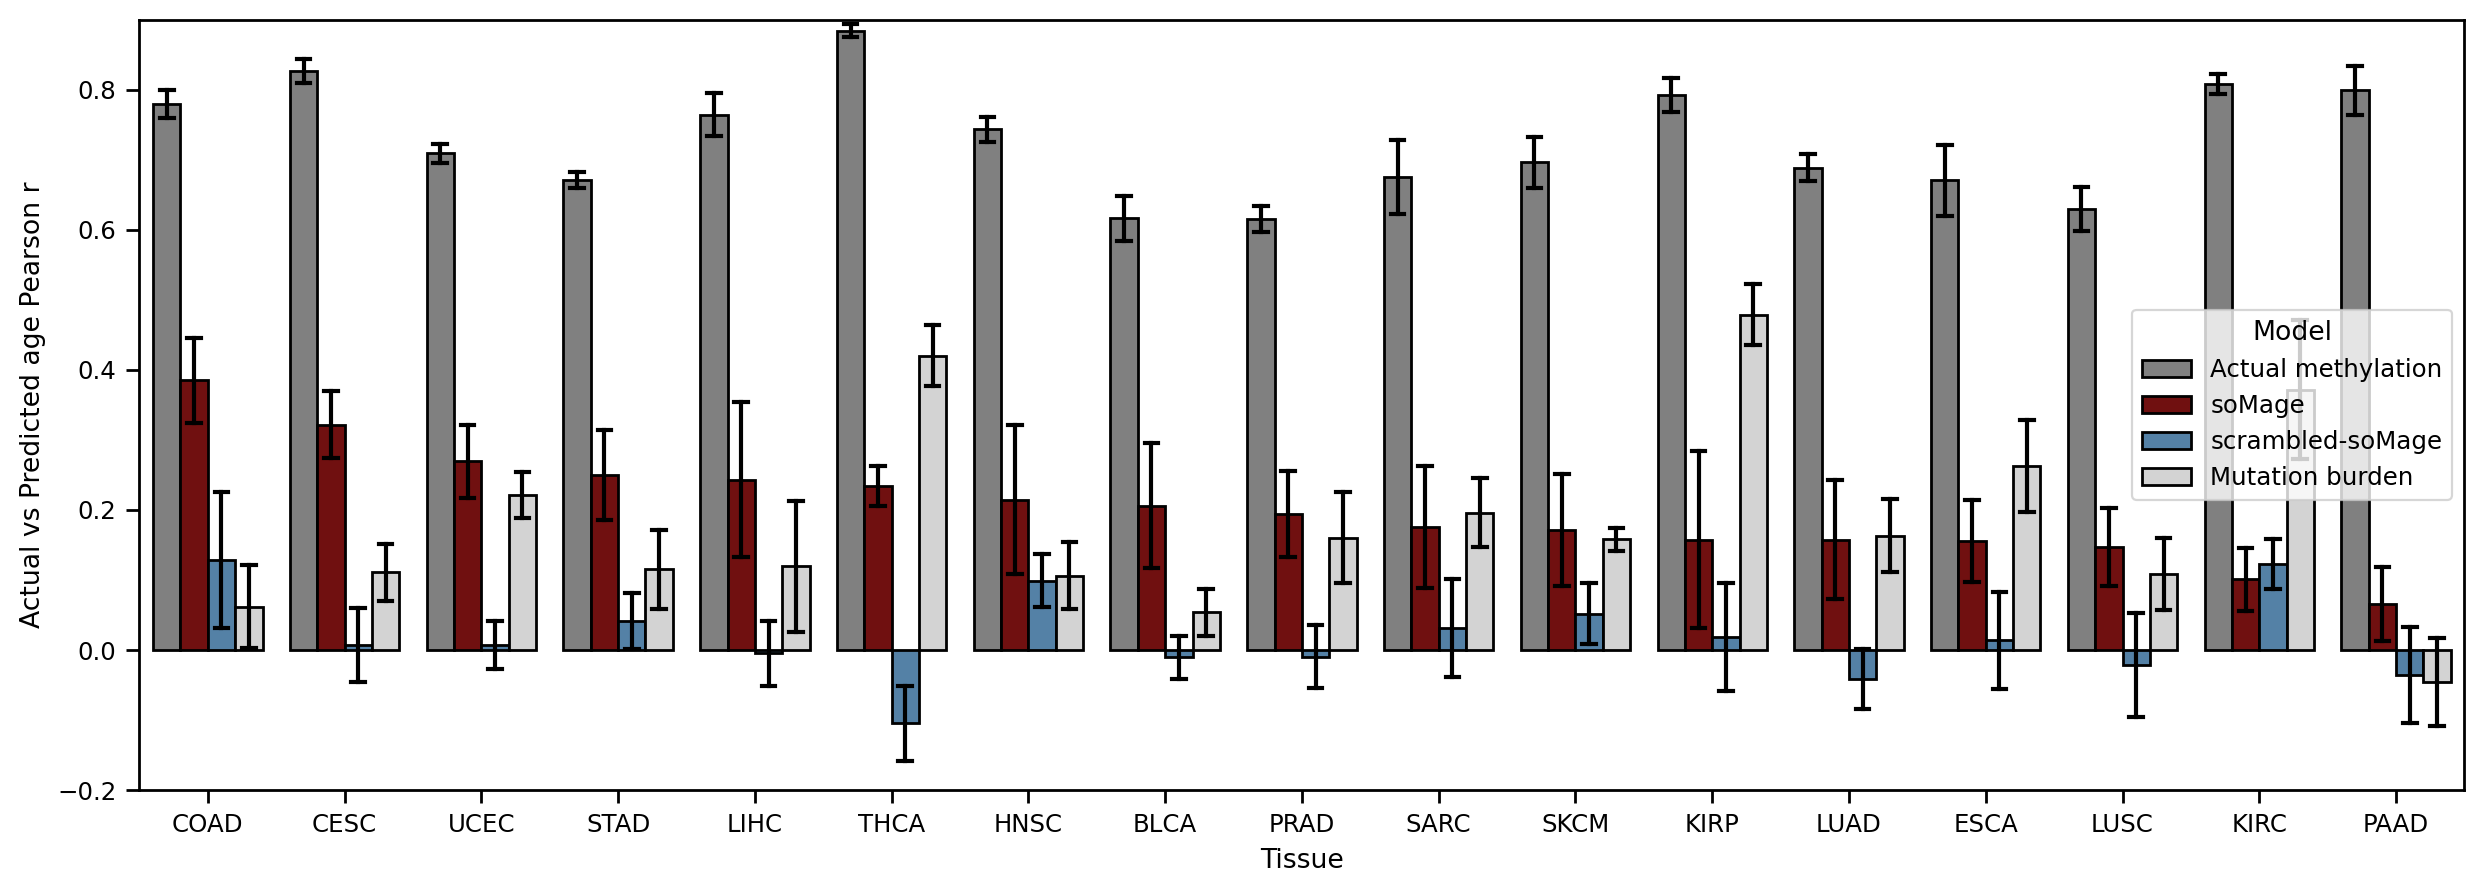

In [264]:
fig, axes = plt.subplots(figsize = (15,5), dpi = 100)
sns.set_context('paper')
# get mean value of pearson for each dataset 
filtered_df = best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
scramble_filtered_df = scramble_best_clock_results_df.query("cpg_choosing_metric == 'train_Amethyl_v_Age_pearson_abs' and training_methylation_type == 'pred' and number_of_cpg == 500")
# combine 
filtered_df['Model'] = 'soMage'
scramble_filtered_df['Model'] = 'scrambled-soMage'
mut_burden_perf_df['Model'] = 'Mutation burden'
combined_df = pd.concat(
    [filtered_df, scramble_filtered_df, actual_performance_df, mut_burden_perf_df]
    ).reset_index(drop=True)
order = filtered_df.groupby('dataset')['pearson'].mean().sort_values(ascending=False).index

sns.barplot(
    data=combined_df,  y = 'pearson', x = 'dataset', hue = 'Model',
    ax = axes, errorbar = 'se', capsize=.1, linewidth=1,
    errcolor="black", errwidth=1.5, order  = order,
    palette = ['grey', 'maroon', 'steelblue', 'lightgrey'], edgecolor = 'black',
    hue_order=[ 'Actual methylation', 'soMage', 'scrambled-soMage', 'Mutation burden']
    )
plt.ylabel('Actual vs Predicted age Pearson r')
plt.xlabel('Tissue')
# do not show legend
#axes.get_legend().remove()
plt.ylim(-0.2, 0.9)
#plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5E_clock_performance_barplots.svg', dpi=300, format = 'svg')


#sns.stripplot(data=filtered_df,  y = 'pearson', x = 'dataset', ax = axes, order = order, color = 'black', alpha = 0.5)

# angle the x labels
#_=plt.xticks(rotation=45, ha='right')

Text(0.5, 1.0, 'CESC mutation burden vs age (One example fold of 5CV)')

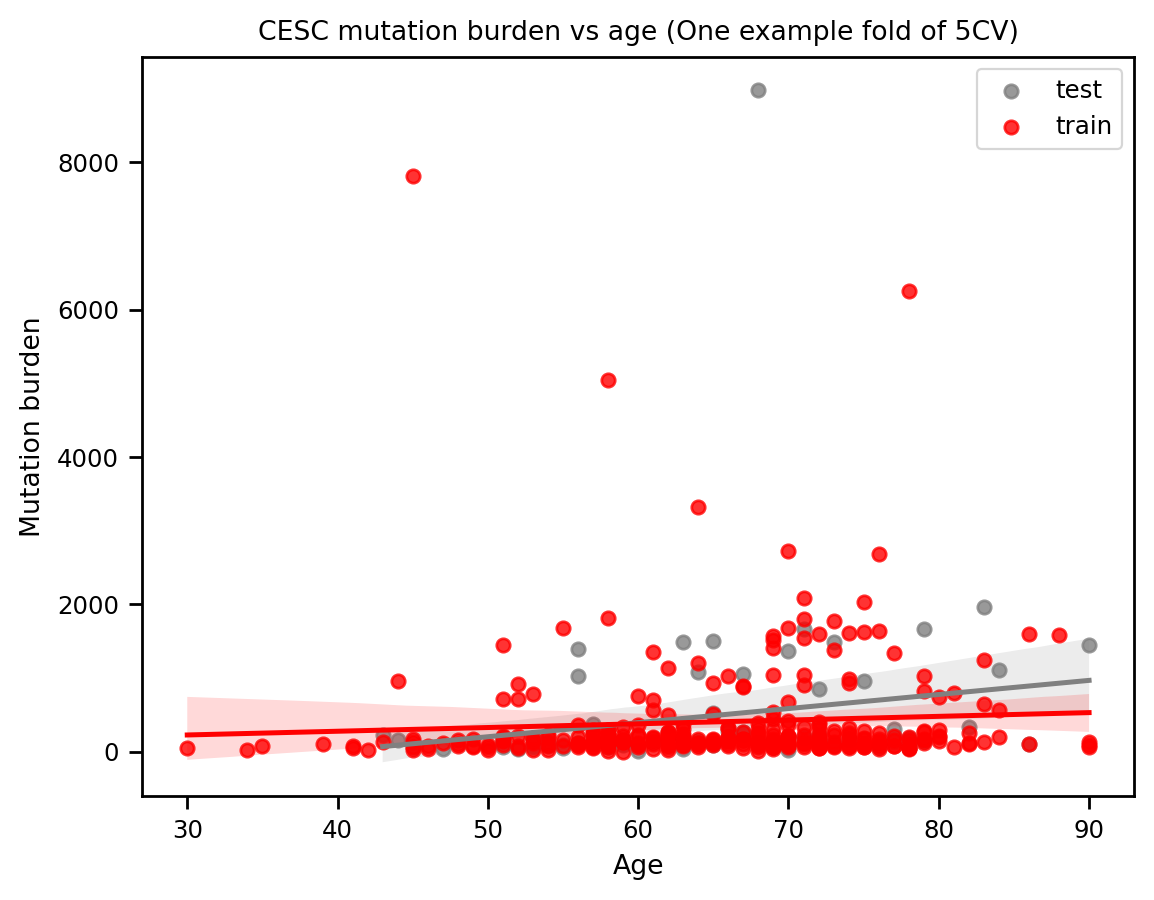

In [262]:
dataset = 'STAD'
this_dataset_df = mut_burden_df.query("dataset == @dataset").reset_index(drop=True)
# split into train and test sets and iterate
cv = KFold(n_splits=5, shuffle=True, random_state=4)
test_samples = []
train_samples = []
for train_index, test_index in cv.split(this_dataset_df):
    test_samples.extend(test_index.tolist())
    train_samples.extend(train_index.tolist())
    break
sns.regplot(data = this_dataset_df.loc[test_samples], x = 'age', y = 'mut_burden', color = 'grey', label = 'test')
sns.regplot(data = this_dataset_df.loc[train_samples], x = 'age', y = 'mut_burden', color = 'red', label = 'train')
plt.legend()
plt.xlabel('Age')
plt.ylabel('Mutation burden')
plt.title('CESC mutation burden vs age (One example fold of 5CV)')
#plt.ylim(0, 2500)

In [253]:
len(train_samples)

1036

In [252]:
len(test_samples)

259

AttributeError: 'list' object has no attribute 'min'

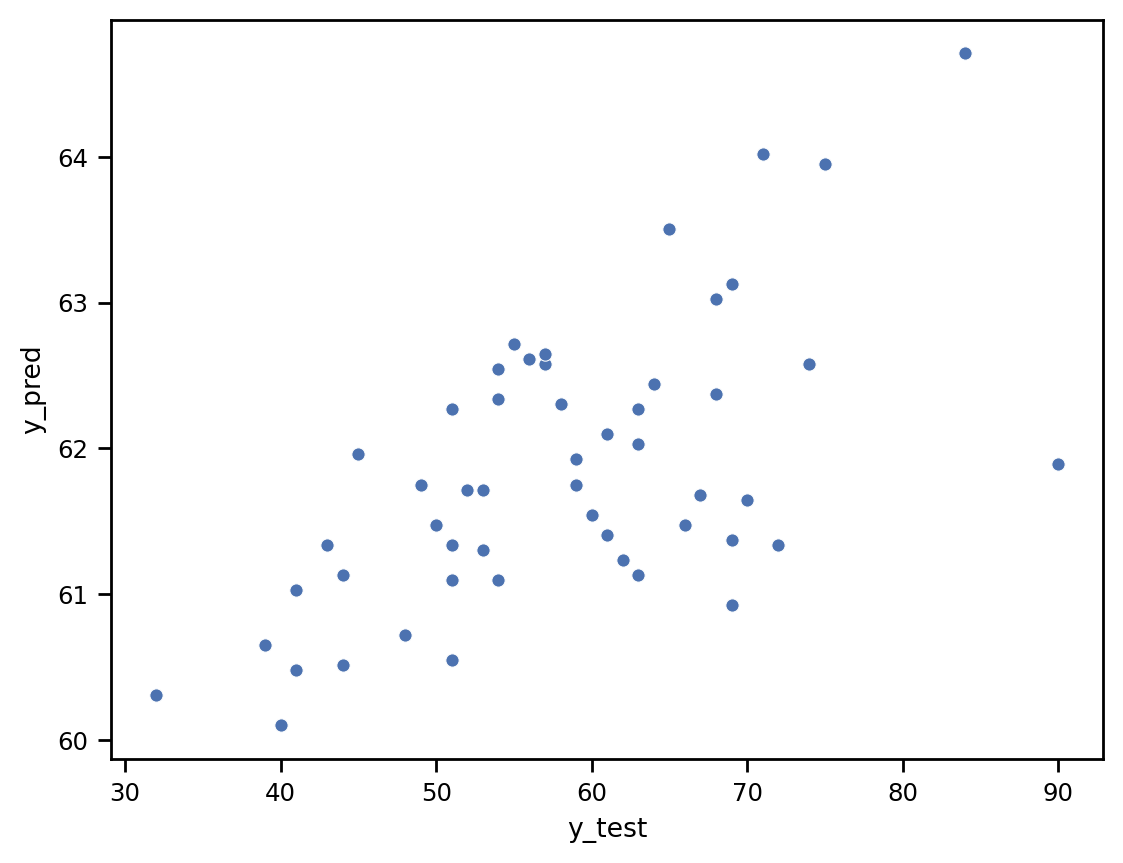

In [137]:
sns.scatterplot(data = combined_df.loc[295], x = 'y_test', y = 'y_pred')#, hue = 'dataset')
# plot y=x line
plt.plot([combined_df.loc[295, 'y_test'].min(), combined_df.loc[295, 'y_test'].max()], [combined_df.loc[295, 'y_test'].min(), combined_df.loc[295, 'y_test'].max()], color = 'black', linestyle = '--')

## ICGC

#### Load the data

In [206]:
mut_feat_icgc_dict = {}
somage_icgc_dict = {}

# for each cv iteration
for cv_num in [0, 1]:
    # create a mutation features object
    mut_feat_icgc = mutation_features.mutationFeatures(
        all_mut_w_age_df = icgc_mut_w_age_df, illumina_cpg_locs_df = illumina_cpg_locs_df, 
        all_methyl_age_df_t = icgc_methyl_age_df_t, out_dir = "./", 
        consortium = 'ICGC', dataset = '', cross_val_num = cv_num,
        matrix_qtl_dir = icgc_matrix_qtl_dir,
        covariate_fn = icgc_covariate_fn, motif_occurence_df = pd.DataFrame()
    )
    # add to dictionary
    mut_feat_icgc_dict[cv_num] = mut_feat_icgc
    # and create a somage object from the seperate somage outputs
    somage_icgc = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output",
        directory_glob = f"ICGC__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_nonebaseline_agg_only",
        mut_feat = mut_feat_icgc,
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = icgc_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output"
        )
    # read in pre-comp prediction performance by dset
    somage_icgc.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    somage_icgc_dict[cv_num] = somage_icgc

Creating soMage object


The least populated class in y has only 1 members, which is less than n_splits=5.


Creating soMage object


The least populated class in y has only 1 members, which is less than n_splits=5.


In [207]:
scrambled_somage_icgc_dict = {}
# for each cv iteration
for cv_num in [0, 1]:
    # and create a somage object from the seperate somage outputs
    scrambled_somage_icgc = somatic_mut_clock.mutationClock.construct_from_paths(
        somage_path = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output",
        directory_glob = f"ICGC__500correl_200meqtl_100000nearby_Bothagg_1000numCpGs_*startTopCpGs_500extendAmount_{cv_num}crossValNum",
        file_suffix = "xgboost_scramblebaseline_agg_only",
        mut_feat = mut_feat_icgc_dict[cv_num],
        illumina_cpg_locs_df = illumina_cpg_locs_df,
        all_methyl_age_df_t = icgc_methyl_age_df_t,
        out_dir = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output"
        )
    # read in pre-comp prediction performance by dset
    scrambled_somage_icgc.performance_by_dataset_df = pd.read_parquet(f"/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/scrambled_pred_methyl_and_perf_by_dset/performance_by_dataset_CV{cv_num}.parquet")
    # add to dictionary
    scrambled_somage_icgc_dict[cv_num] = somage_icgc

Creating soMage object
Creating soMage object


#### ICGC Figure 5B

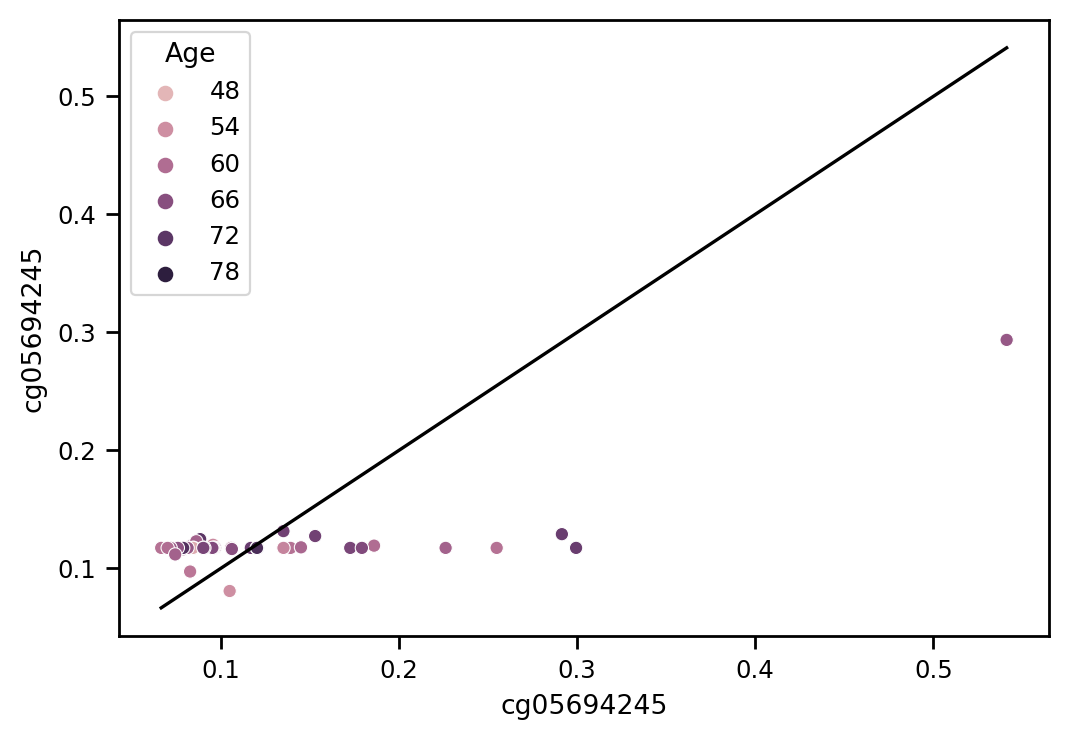

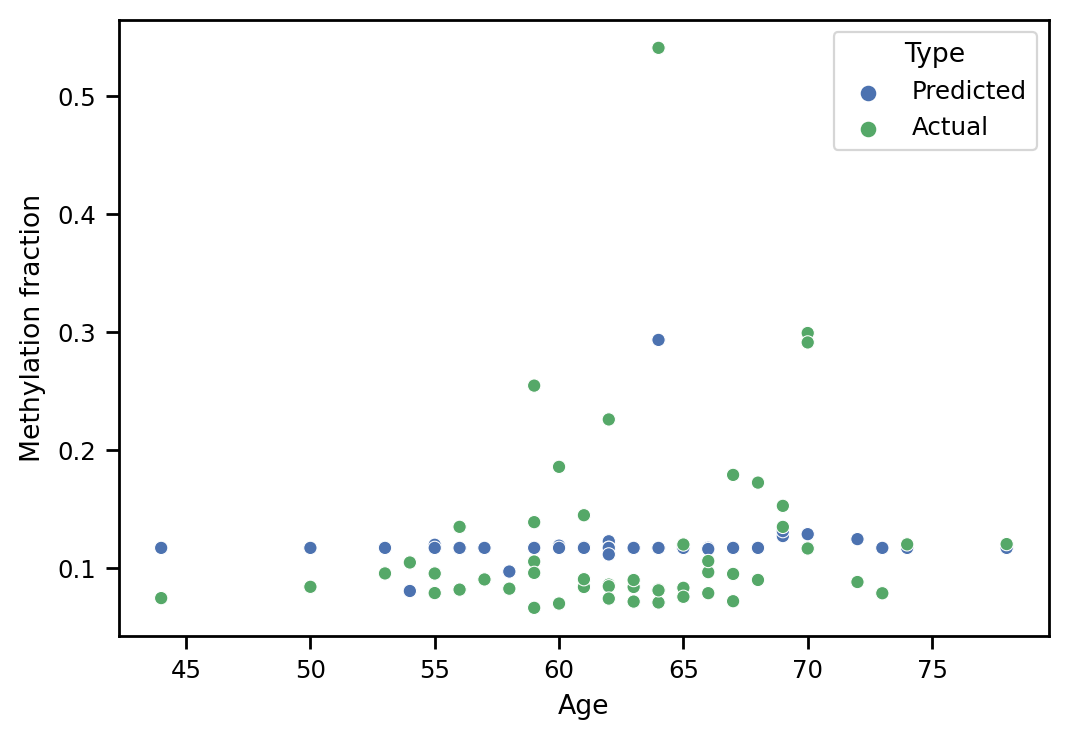

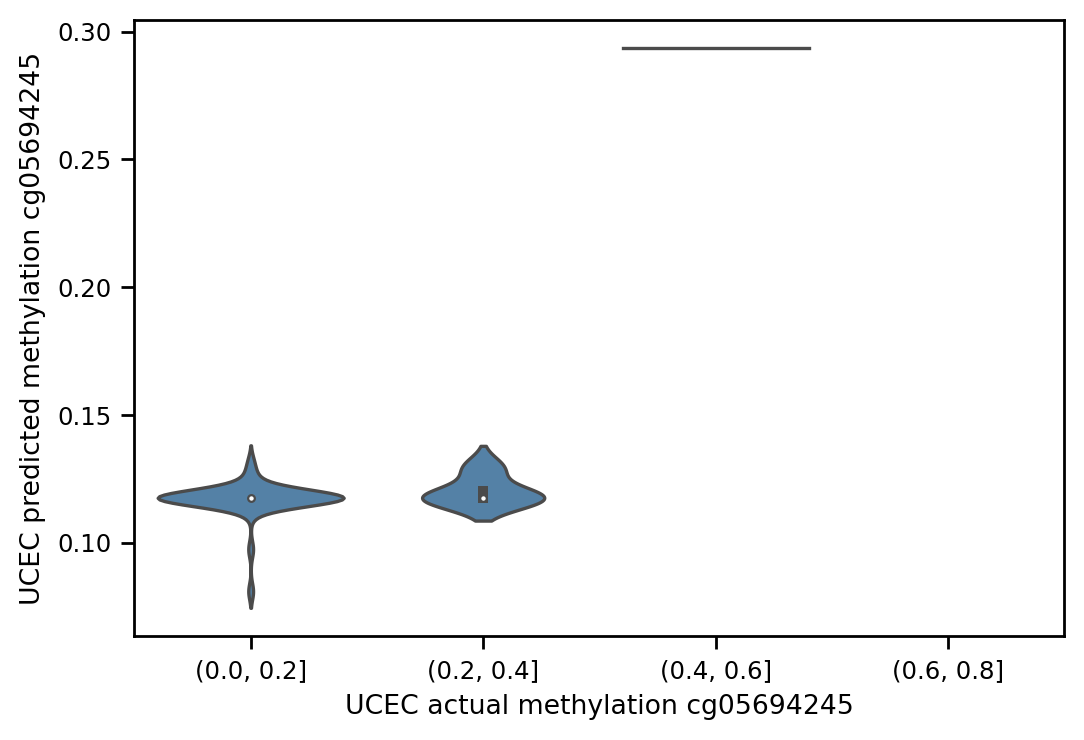

In [62]:
somage.plot_real_vs_predicted_methylation(
    cpg = 'cg05694245', dataset = 'PRAD', sample_set='test'
    )

#### ICGC 5C

In [53]:
somage.performance_by_dataset_df['model'] = 'soMage'
somage_scrambled.performance_by_dataset_df['model'] = 'scrambled-soMage'
combined_perf_df = pd.concat(
    [somage.performance_by_dataset_df, somage_scrambled.performance_by_dataset_df]
    ).reset_index(drop=True)


<Axes: xlabel='train_AvP_methyl_pearson', ylabel='Probability'>

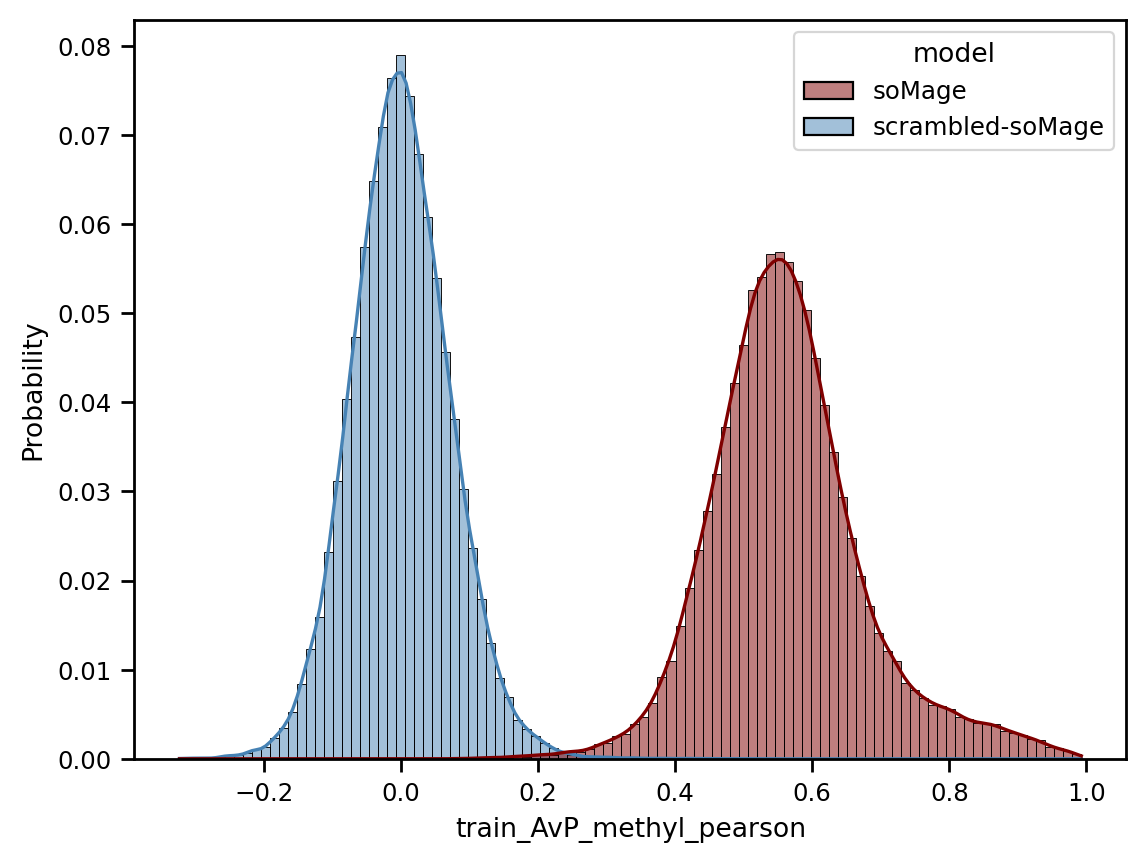

In [54]:
# training set
sns.histplot(
    data = combined_perf_df.query("dataset == 'PRAD'"),
    x = 'train_AvP_methyl_pearson', hue = 'model', bins = 100,
    log_scale=[False,False], stat = 'probability', common_norm=False,
    palette=['maroon', 'steelblue'], kde = True
    )

<Axes: xlabel='AvP_methyl_pearson', ylabel='Probability'>

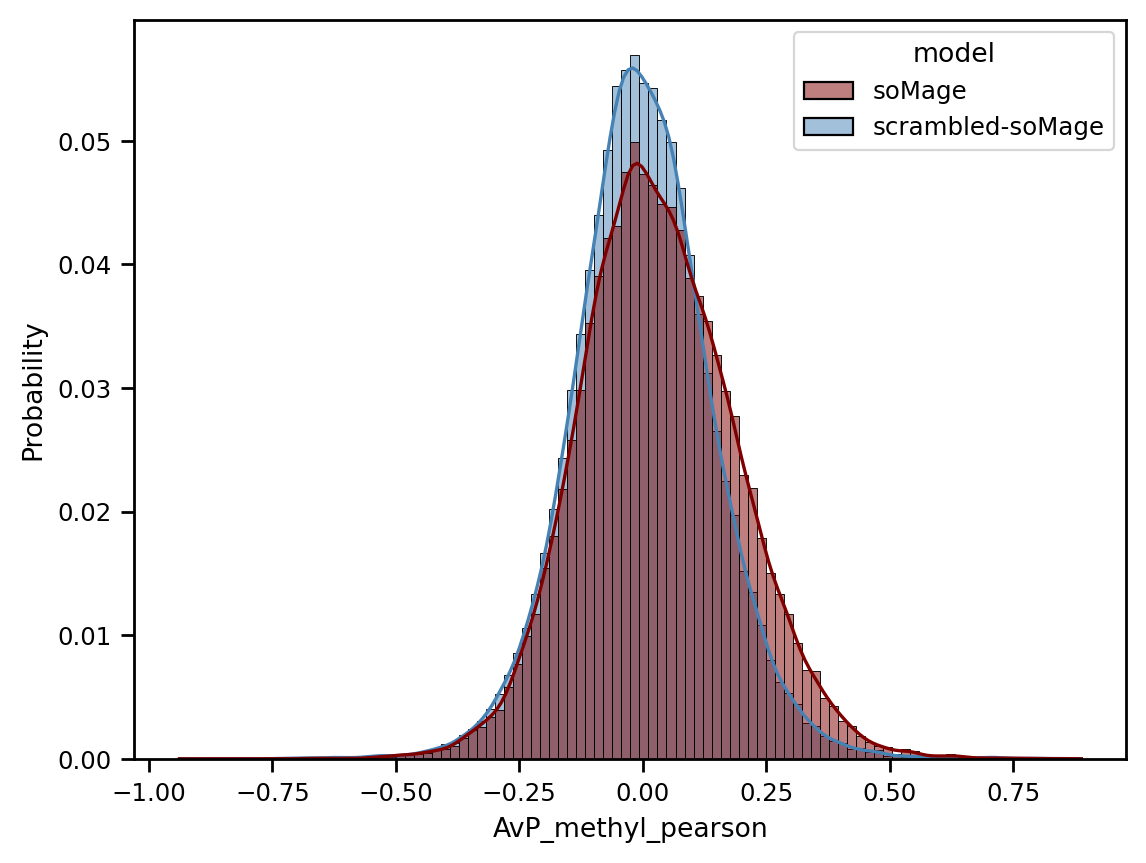

In [55]:
# testing set
sns.histplot(
    data = combined_perf_df.query("dataset == 'PRAD'"),
    x = 'AvP_methyl_pearson', hue = 'model', bins = 100,
    log_scale=[False,False], stat = 'probability', common_norm=False,
    palette=['maroon', 'steelblue'], kde = True
    )

#### ICGC 5E: performance barplots

In [ ]:
icgc_best_clock_results = {}
for cv_num in [0,1]:
    icgc_best_clock_results[cv_num] = somage_icgc_dict[cv_num].scan_for_best_clock(
        datasets = somage_icgc_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics =['train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],#, 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
        number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
        training_methylation_types = ['pred', 'actual'],
        train_sets = ['train'],
        model_types = ['xgboost'], # 'elasticnet', 
        train_tissues = ['self']
        )
# write to pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/trained_clocks/2_folds_best_clocks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(icgc_best_clock_results, f)
# read from pickle
"""fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/trained_clocks/2_folds_best_clocks.pkl"
with open(fn, 'rb') as f:
    icgc_best_clock_results = pickle.load(f)"""
    
# combine best_clock_results dict into df
icgc_best_clock_results_list = []
for cv_num in [0,1]:
    icgc_best_clock_results[cv_num]['cv_num'] =  cv_num
    icgc_best_clock_results_list.append(icgc_best_clock_results[cv_num])
icgc_best_clock_results_df = pd.concat(icgc_best_clock_results_list).reset_index(drop=True)

In [ ]:
icgc_scrambled_best_clock_results = {}
for cv_num in [0,1]:
    icgc_scrambled_best_clock_results[cv_num] = scrambled_somage_icgc_dict[cv_num].scan_for_best_clock(
        datasets = scrambled_somage_icgc_dict[cv_num].performance_by_dataset_df['dataset'].unique().tolist(),
        cpg_choosing_metrics =['train_AvP_methyl_pearson', 'train_Amethyl_v_Age_pearson_abs'],#, 'train_AvP_methyl_mi', 'train_Pmethyl_v_Age_mi'],
        number_of_cpgs = [10, 50, 500, 2500, 10000, 25000],
        training_methylation_types = ['pred', 'actual'],
        train_sets = ['train'],
        model_types = ['xgboost'], # 'elasticnet', 
        train_tissues = ['self']
        )
# write to pickle
fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/trained_clocks/scramble_2_folds_best_clocks.pkl"
with open(fn, 'wb') as f:
    pickle.dump(icgc_scrambled_best_clock_results, f)
# read from pickle
"""fn = "/cellar/users/zkoch/methylation_and_mutation/output_dirs/051723_icgc_somage_output/trained_clocks/scramble_2_folds_best_clocks.pkl"
with open(fn, 'rb') as f:
    icgc_scrambled_best_clock_results = pickle.load(f)"""
    
# combine best_clock_results dict into df
icgc_scrambled_best_clock_results_list = []
for cv_num in [0,1]:
    icgc_scrambled_best_clock_results[cv_num]['cv_num'] =  cv_num
    icgc_scrambled_best_clock_results_list.append(icgc_scrambled_best_clock_results[cv_num])
icgc_scrambled_best_clock_results_df = pd.concat(icgc_scrambled_best_clock_results_list).reset_index(drop=True)

In [210]:
# read in actual clock results
# read in all sample model and make predictions
clock_dir = "/cellar/users/zkoch/methylation_and_mutation/data/final_icgc_data/actual_methyl_epi_clocks"
icgc_real_methyl_models = {}
icgc_performances = []
dsets = icgc_best_clock_results_df['dataset'].unique().tolist()
# read from pickle
for cv_num in [0,1]:
    with open(os.path.join(clock_dir, f'epiClock_ICGC_cv{cv_num}_all_actualMethyl_enet.pkl'), 'rb') as f:
        all_sample_model = pickle.load(f)
    icgc_real_methyl_models[cv_num] = all_sample_model
    for dataset in dsets:
        # get this cv_num test samples
        test_samples = mut_feat_icgc_dict[cv_num].test_samples
        # and intersect with this datasets samples
        test_samples = list(
            set(test_samples).intersection(
                set(icgc_methyl_age_df_t.query("dataset == @dataset").index.tolist())
            ))
        # make prediction
        predicted_ages = all_sample_model.predict(icgc_methyl_age_df_t.loc[test_samples].iloc[:, 3:])
        actual_ages = icgc_methyl_age_df_t.loc[test_samples, 'age_at_index'].values
        pearson = pearsonr(predicted_ages, actual_ages)[0]
        spearman = spearmanr(predicted_ages, actual_ages)[0]
        icgc_performances.append({
            'dataset': dataset,
            'cv_num': cv_num,
            'pearson': pearson,
            'spearman': spearman,
            'Model': 'Actual methylation',
            'y_pred': predicted_ages,
            'y_test': actual_ages
            })
        
    print(f"Done with cv_num {cv_num}", flush = True)
        
icgc_actual_performance_df = pd.DataFrame(icgc_performances)

Done with cv_num 0
Done with cv_num 1


In [224]:
icgc_best_clock_results_df.query("dataset == 'PRAD' or dataset == 'PACA'")

,dataset,cpg_choosing_metric,number_of_cpg,training_methylation_type,train_set,model_type,train_tissue,pearson,spearman,trained_clock,y_pred,y_test,cv_num
10,PACA,train_AvP_methyl_pearson,10,actual,train,xgboost,self,0.581130,0.685883,"XGBRegressor(base_score=None, booster=None, ca...","[72.72089, 63.527233, 67.615265, 61.12253, 65....",sample DO32851 84 DO32996 59 DO32825 ...,0
23,PRAD,train_AvP_methyl_pearson,10000,pred,train,xgboost,self,0.390414,0.325577,"XGBRegressor(base_score=None, booster=None, ca...","[59.123188, 63.71403, 62.741592, 62.840477, 63...",sample DO230614 67 DO51114 62 DO51084 ...,0
25,PACA,train_AvP_methyl_pearson,50,pred,train,xgboost,self,0.362183,0.369125,"XGBRegressor(base_score=None, booster=None, ca...","[73.50253, 68.99975, 68.08798, 62.244537, 69.1...",sample DO32851 84 DO32996 59 DO32825 ...,0
32,PACA,train_AvP_methyl_pearson,500,pred,train,xgboost,self,0.294669,0.341944,"XGBRegressor(base_score=None, booster=None, ca...","[69.58572, 68.30347, 65.48081, 64.28872, 66.44...",sample DO32851 84 DO32996 59 DO32825 ...,0
33,PACA,train_AvP_methyl_pearson,10,pred,train,xgboost,self,0.285533,0.264385,"XGBRegressor(base_score=None, booster=None, ca...","[72.07656, 64.69711, 72.036545, 60.576527, 74....",sample DO32851 84 DO32996 59 DO32825 ...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
266,PACA,train_AvP_methyl_pearson,10000,actual,train,xgboost,self,-0.165615,-0.273952,"XGBRegressor(base_score=None, booster=None, ca...","[72.11327, 73.69172, 69.59961, 57.708115, 60.8...",sample DO33592 61 DO33256 65 DO49185 ...,1
268,PACA,train_Amethyl_v_Age_pearson_abs,10000,pred,train,xgboost,self,-0.178388,-0.105602,"XGBRegressor(base_score=None, booster=None, ca...","[63.516823, 71.514854, 67.42954, 65.034546, 66...",sample DO33592 61 DO33256 65 DO49185 ...,1
270,PRAD,train_AvP_methyl_pearson,2500,actual,train,xgboost,self,-0.191642,-0.219210,"XGBRegressor(base_score=None, booster=None, ca...","[67.31677, 66.078735, 68.2128, 66.636444, 68.4...",sample DO230546 62 DO51086 70 DO229451 ...,1
272,PRAD,train_AvP_methyl_pearson,10,pred,train,xgboost,self,-0.200130,-0.183722,"XGBRegressor(base_score=None, booster=None, ca...","[62.323433, 67.391525, 64.41811, 61.234467, 65...",sample DO230546 62 DO51086 70 DO229451 ...,1


<Axes: xlabel='number_of_cpg', ylabel='pearson'>

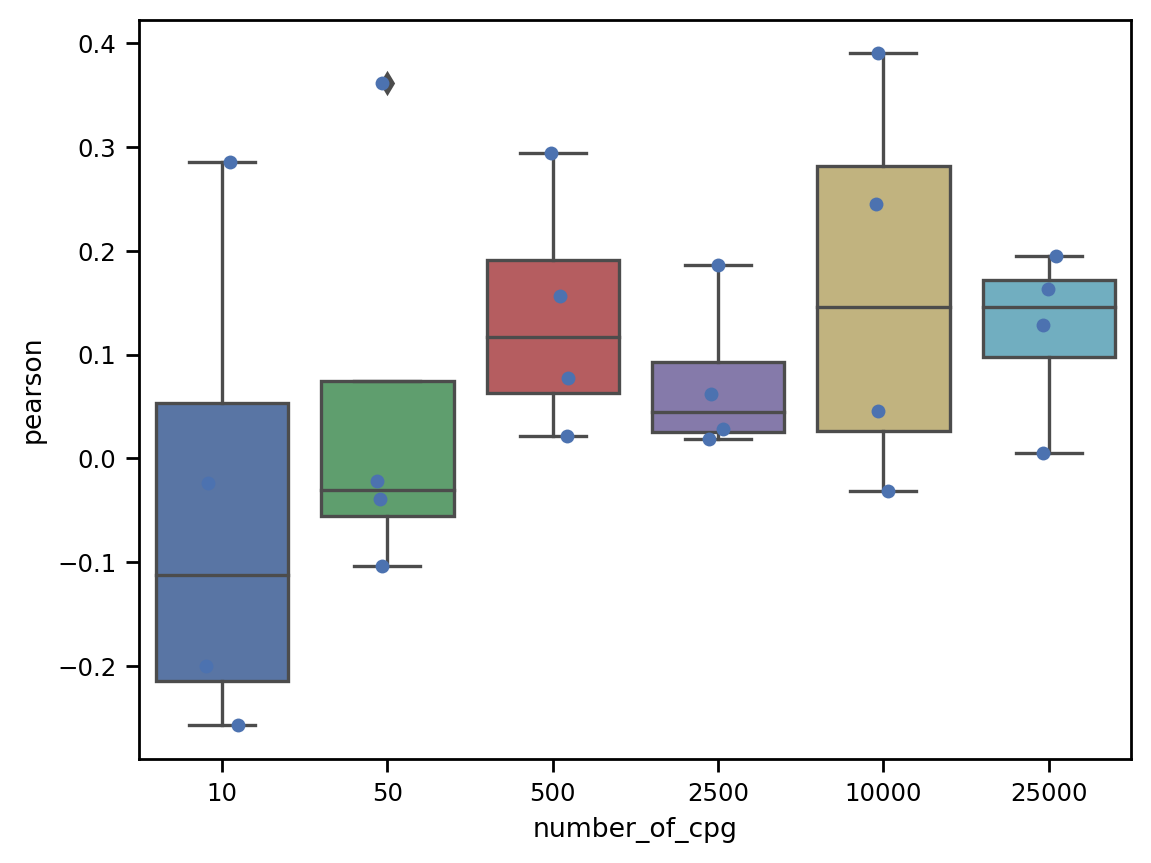

In [222]:
sns.boxplot(data = icgc_best_clock_results_df.query("(dataset == 'PRAD' or dataset == 'PACA') and training_methylation_type == 'pred' and cpg_choosing_metric == 'train_AvP_methyl_pearson'"), x = 'number_of_cpg', y = 'pearson')
sns.stripplot(data = icgc_best_clock_results_df.query("(dataset == 'PRAD' or dataset == 'PACA') and training_methylation_type == 'pred'  and cpg_choosing_metric == 'train_AvP_methyl_pearson'"), x = 'number_of_cpg', y = 'pearson')
# pred methyl is better
# train_AvP_methyl_pearson is better



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


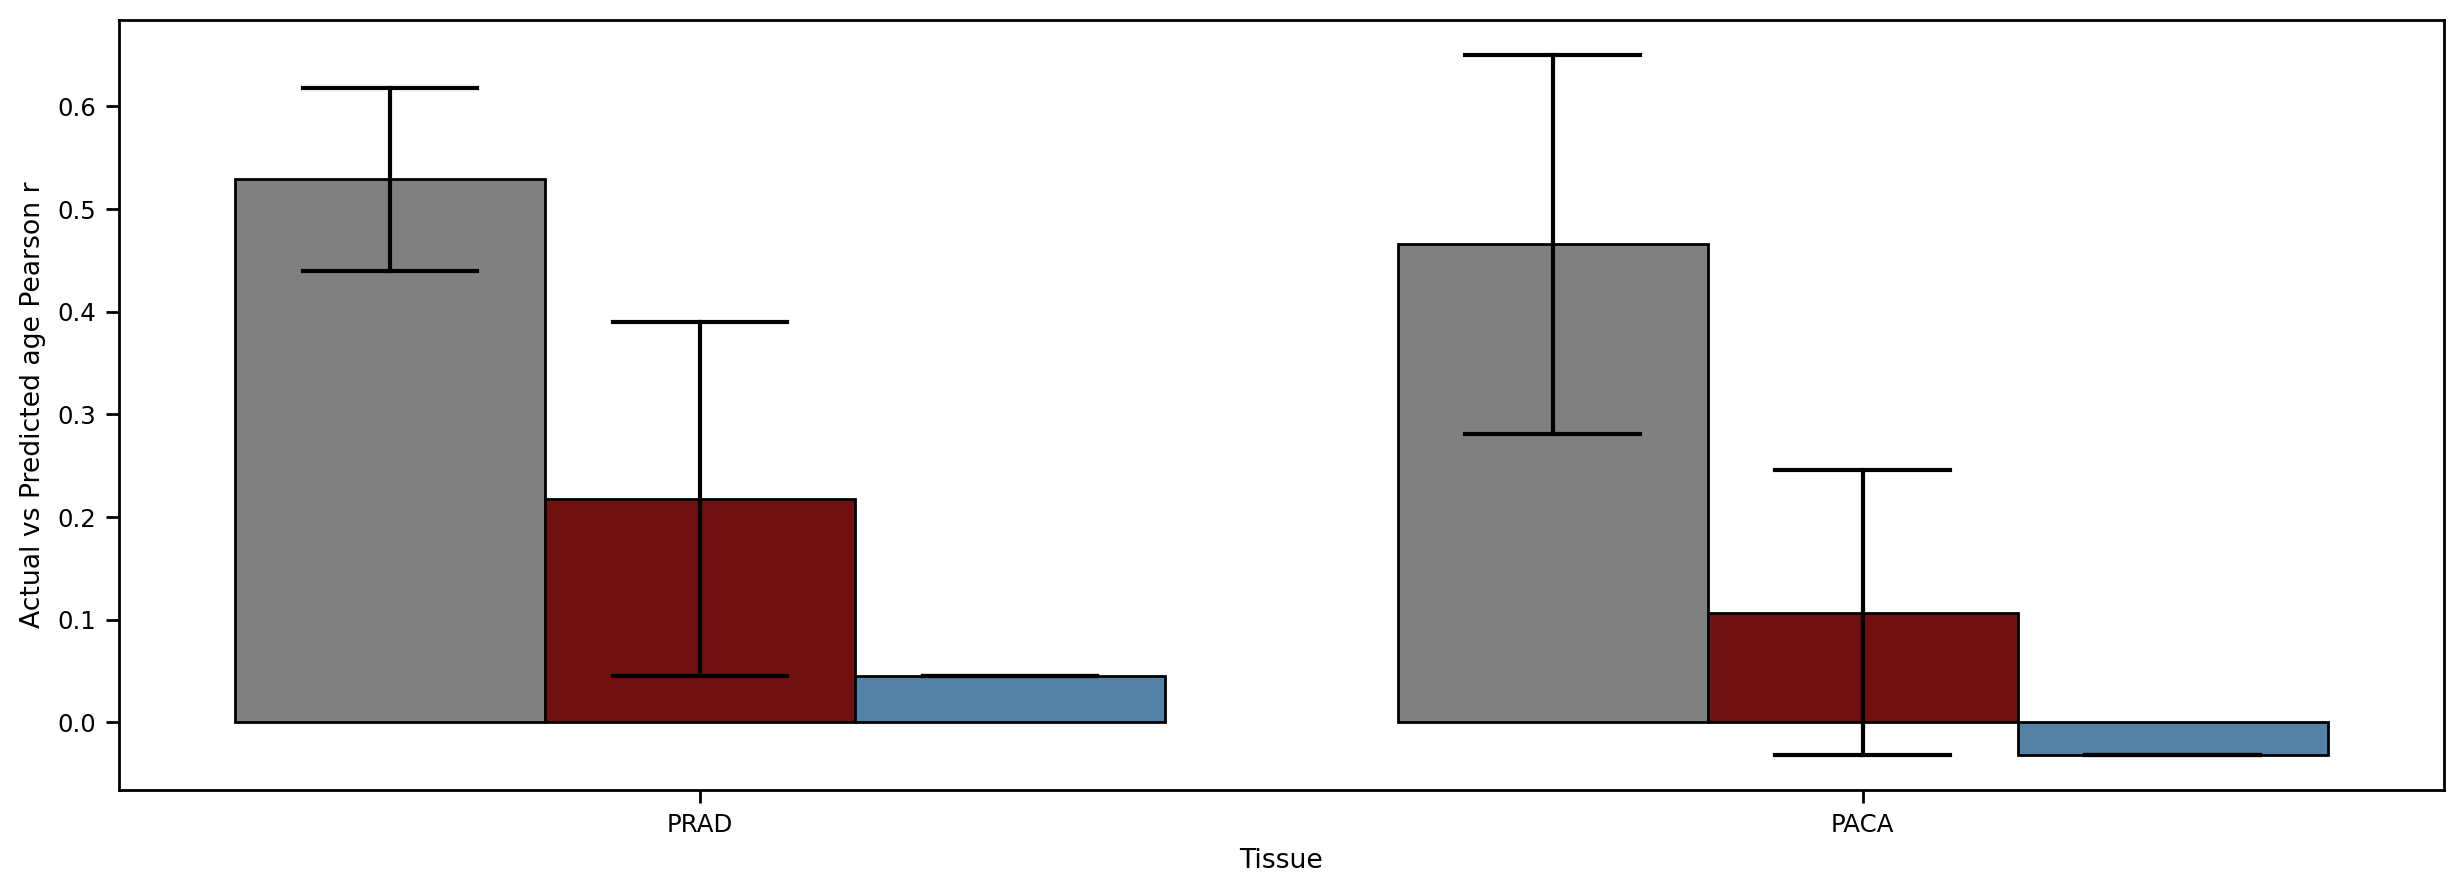

In [230]:
fig, axes = plt.subplots(figsize = (15,5), dpi = 100)
sns.set_context('paper')
# get mean value of pearson for each dataset 
filtered_df = icgc_best_clock_results_df.query("cpg_choosing_metric == 'train_AvP_methyl_pearson' and training_methylation_type == 'pred' and number_of_cpg == 10000 and (dataset == 'PRAD' or dataset == 'PACA')")
scramble_filtered_df = icgc_scrambled_best_clock_results_df.query("cpg_choosing_metric == 'train_AvP_methyl_pearson' and training_methylation_type == 'pred' and number_of_cpg == 10000 and (dataset == 'PRAD' or dataset == 'PACA')")
# combine 
filtered_df['Model'] = 'soMage'
scramble_filtered_df['Model'] = 'scrambled-soMage'
combined_df = pd.concat(
    [filtered_df, scramble_filtered_df, icgc_actual_performance_df]
    ).reset_index(drop=True)
order = filtered_df.groupby('dataset')['pearson'].mean().sort_values(ascending=False).index

sns.barplot(
    data=combined_df,  y = 'pearson', x = 'dataset', hue = 'Model',
    ax = axes, errorbar = 'se', capsize=.15, linewidth=1,
    errcolor="black", errwidth=1.5, order  = order,
    palette = ['grey', 'maroon', 'steelblue'], edgecolor = 'black',
    hue_order=[ 'Actual methylation', 'soMage', 'scrambled-soMage']
    )
plt.ylabel('Actual vs Predicted age Pearson r')
plt.xlabel('Tissue')
# do not show legend
axes.get_legend().remove()
#plt.ylim(-0.2, 0.9)
#plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5E_clock_performance_barplots.svg', dpi=300, format = 'svg')


#sns.stripplot(data=filtered_df,  y = 'pearson', x = 'dataset', ax = axes, order = order, color = 'black', alpha = 0.5)

# angle the x labels
#_=plt.xticks(rotation=45, ha='right')

#### Mutation burden predicting age

In [178]:
icgc_mut_burden = icgc_mut_w_age_df['case_submitter_id'].value_counts()
icgc_ct_mut_burden = icgc_mut_w_age_df.loc[icgc_mut_w_age_df['mutation'] == 'C>T', 'case_submitter_id'].value_counts()
icgc_age = icgc_methyl_age_df_t['age_at_index']
icgc_dataset = icgc_methyl_age_df_t['dataset']
# merge these into a df
icgc_mut_burden_df = pd.DataFrame({
    'mut_burden': icgc_mut_burden,
    'ct_mut_burden': icgc_ct_mut_burden,
    'age': icgc_age,
    'dataset': icgc_dataset
    }).reset_index().rename(columns = {'index': 'case_submitter_id'})
# drop any row with a nan
icgc_mut_burden_df = icgc_mut_burden_df.dropna().reset_index(drop=True)
icgc_mut_burden_df['log_mut_burden'] = np.log(icgc_mut_burden_df['mut_burden'])

In [236]:
icgc_mut_burden_df['dataset'].value_counts()

PRAD    241
PACA    158
OV       92
PBCA     72
CLLE     47
PAEN     21
UTCA     16
Name: dataset, dtype: int64

In [228]:
# build a linear regression model to predict age from mut burden with 5-fold cross validation
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold
from scipy.stats import pearsonr
from sklearn.metrics import mean_absolute_error

model = LinearRegression()
mut_count = 'mut_burden' # 'ct_mut_burden'
performances = []
for dataset in icgc_mut_burden_df['dataset'].unique():
    this_dataset_df = icgc_mut_burden_df.query("dataset == @dataset").reset_index(drop=True)
    # split into train and test sets and iterate
    cv = KFold(n_splits=5, shuffle=True, random_state=4)
    for train_index, test_index in cv.split(this_dataset_df):
        # train the model
        model.fit(this_dataset_df.loc[train_index, mut_count].values.reshape(-1, 1), this_dataset_df.loc[train_index, 'age'])
        # evaluate the model
        pred_ages = model.predict(this_dataset_df.loc[test_index, mut_count].values.reshape(-1, 1))
        # calculate r2
        r = pearsonr(this_dataset_df.loc[test_index, 'age'], pred_ages).statistic
        # calculate mae
        mae = mean_absolute_error(this_dataset_df.loc[test_index, 'age'], pred_ages)
        performances.append(
            {'dataset': dataset, 'pearson': r, 'mae': mae,
             'y_pred': pred_ages.tolist(), 'y_test': this_dataset_df.loc[test_index, 'age'].values.tolist()
             }
            )
icgc_mut_burden_perf_df = pd.DataFrame(performances)



A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


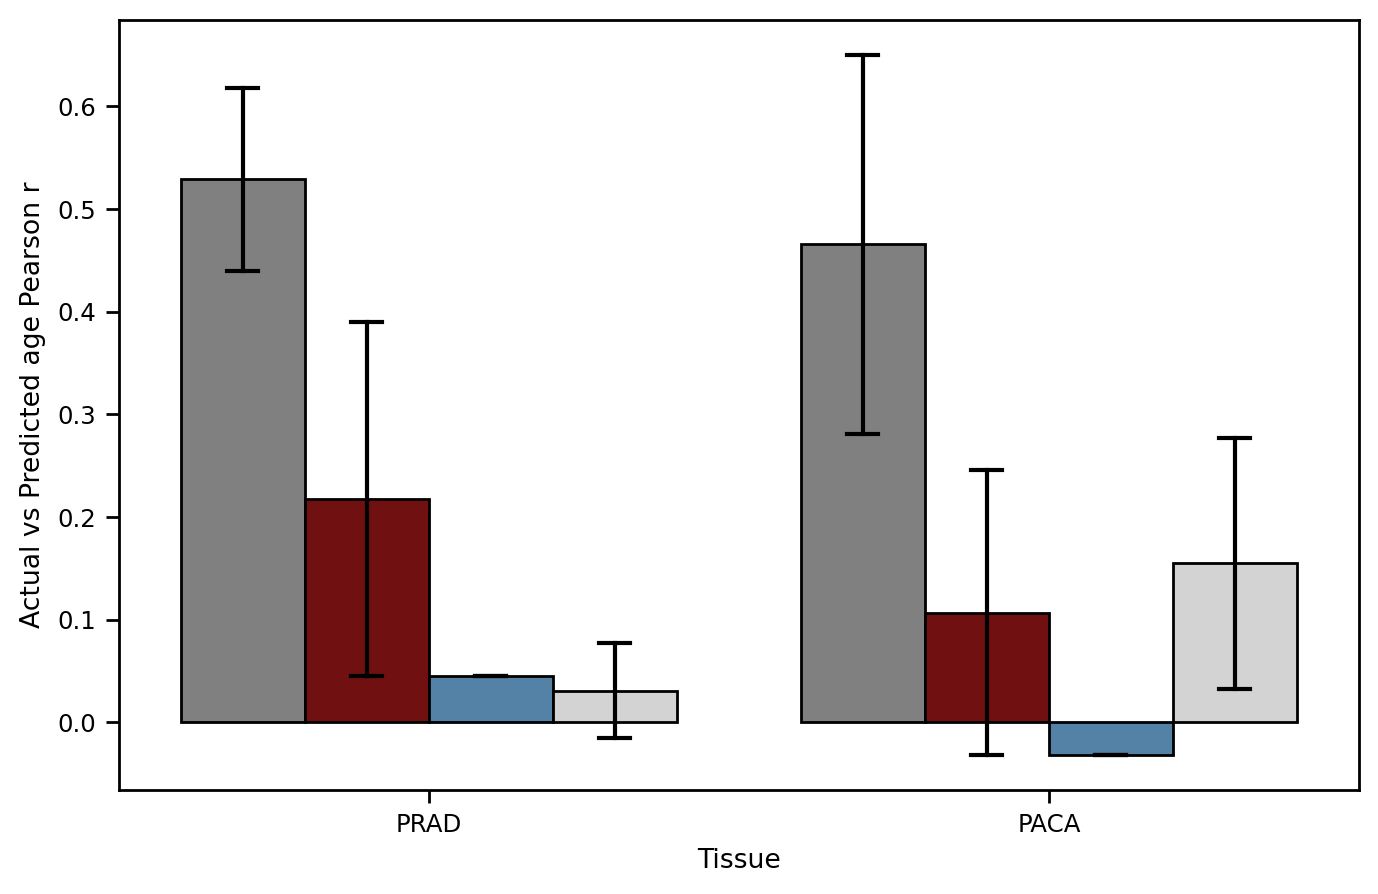

In [235]:
fig, axes = plt.subplots(figsize = (8,5), dpi = 100)
sns.set_context('paper')
# get mean value of pearson for each dataset 
filtered_df = icgc_best_clock_results_df.query("cpg_choosing_metric == 'train_AvP_methyl_pearson' and training_methylation_type == 'pred' and number_of_cpg == 10000 and (dataset == 'PRAD' or dataset == 'PACA')")
scramble_filtered_df = icgc_scrambled_best_clock_results_df.query("cpg_choosing_metric == 'train_AvP_methyl_pearson' and training_methylation_type == 'pred' and number_of_cpg == 10000 and (dataset == 'PRAD' or dataset == 'PACA')")
# combine 
filtered_df['Model'] = 'soMage'
scramble_filtered_df['Model'] = 'scrambled-soMage'
icgc_mut_burden_perf_df['Model'] = 'Mutation burden'
combined_df = pd.concat(
    [filtered_df, scramble_filtered_df, icgc_actual_performance_df, icgc_mut_burden_perf_df.query("dataset == 'PRAD' or dataset == 'PACA'")]
    ).reset_index(drop=True)
order = filtered_df.groupby('dataset')['pearson'].mean().sort_values(ascending=False).index

sns.barplot(
    data=combined_df,  y = 'pearson', x = 'dataset', hue = 'Model',
    ax = axes, errorbar = 'se', capsize=.05, linewidth=1,
    errcolor="black", errwidth=1.5, order  = order,
    palette = ['grey', 'maroon', 'steelblue', 'lightgrey'], edgecolor = 'black',
    hue_order=[ 'Actual methylation', 'soMage', 'scrambled-soMage', 'Mutation burden']
    )

plt.ylabel('Actual vs Predicted age Pearson r')
plt.xlabel('Tissue')
# do not show legend
axes.get_legend().remove()
#plt.ylim(-0.2, 0.9)
#plt.savefig('/cellar/users/zkoch/methylation_and_mutation/output_dirs/final_figures/figure5/figure5E_clock_performance_barplots.svg', dpi=300, format = 'svg')


#sns.stripplot(data=filtered_df,  y = 'pearson', x = 'dataset', ax = axes, order = order, color = 'black', alpha = 0.5)

# angle the x labels
#_=plt.xticks(rotation=45, ha='right')